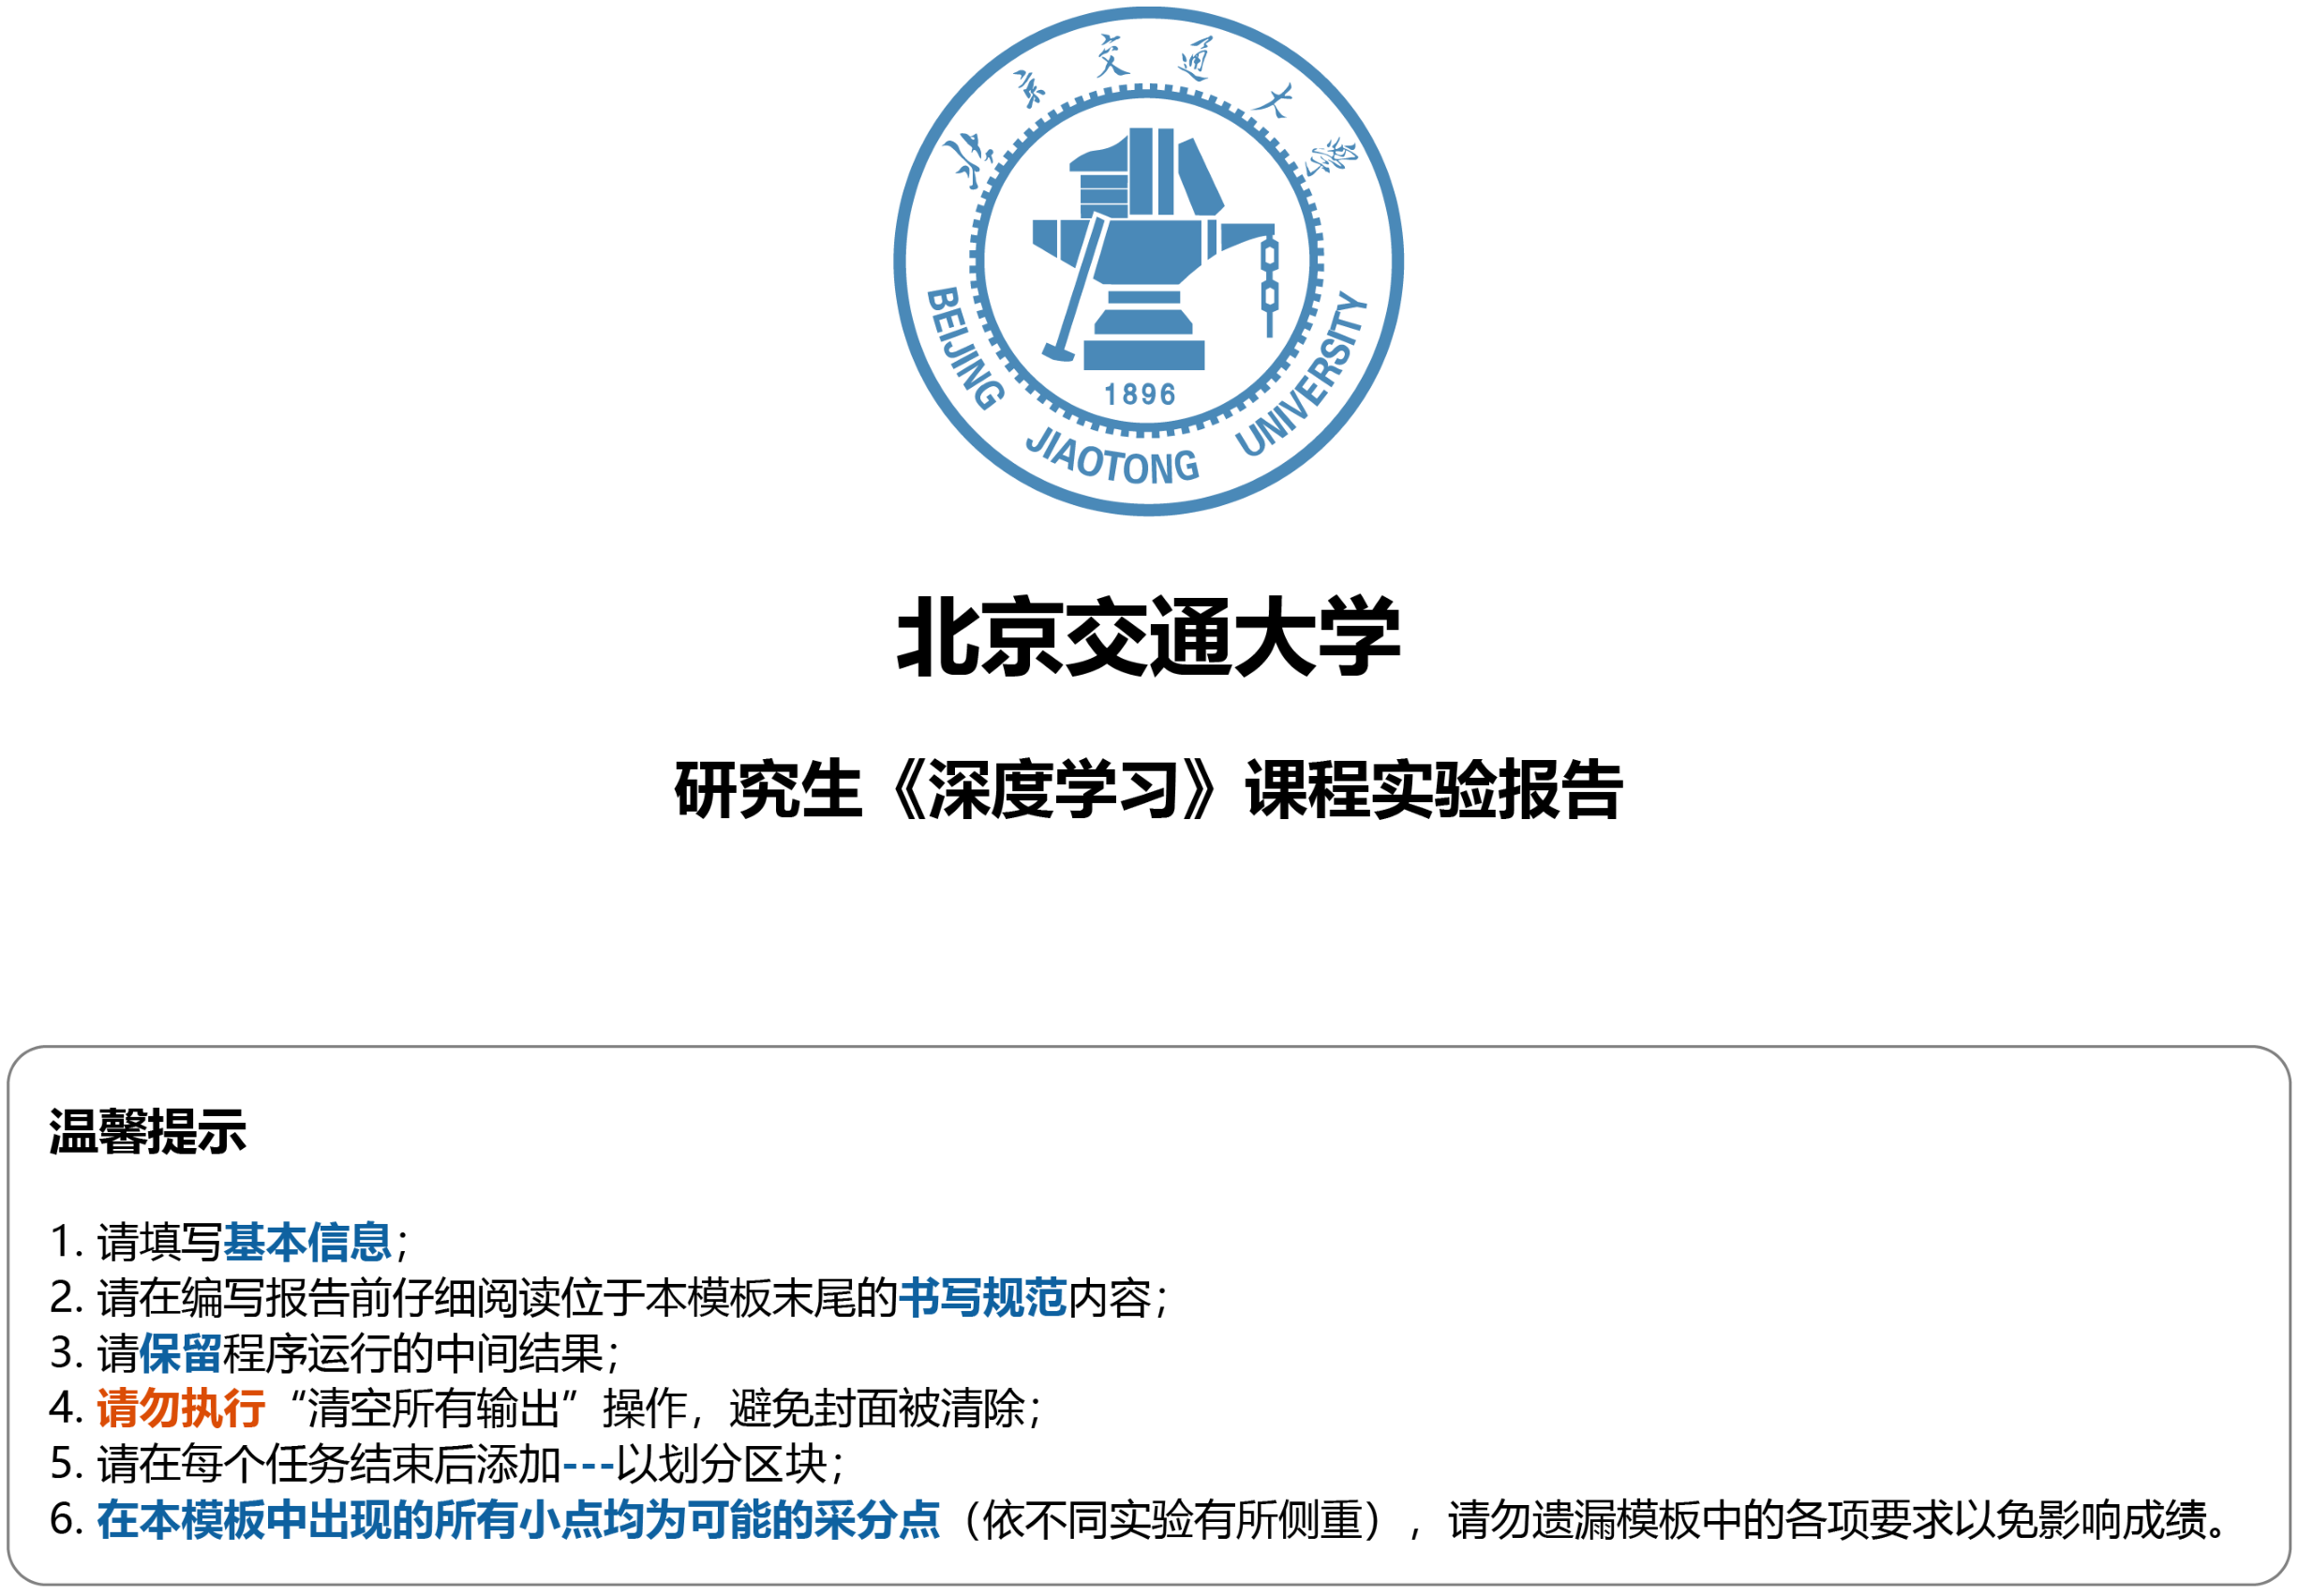

# 基本信息
1. 实验名称：实验4 循环神经网络实验
2. 姓名：尚子轩
3. 学号：22121497
4. 日期：2022.12.3

---

# 一、数据处理

## 1.1 任务内容

1. 任务具体要求
    1. 理解序列数据处理方法，补全面向对象编程中的缺失代码，并使用torch自带数据工具将数据封装为dataloader
2. 任务所用数据集
    1. 高速公路车流量数据

## 1.2 任务思路及代码
1. 导入高速公路车流量数据

In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 128    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)

## 1.3 实验结果分析
根据实验结果可以得知，在数据采用面向对象的方式进行封装的时候，若需要对数据进行输出，输出的内容以存储于某一存储空间方式的形式输出，这种输出恰好是面向对象语言输出的基本形式，由此可以判断数据的预处理正确。

---

# 二、实现循环神经网络

## 2.1 任务内容

1. 任务具体要求
    1. 分别采用手动方式以及调用接口方式实现RNN、LSTM和GRU，并在至少一种数据集上进行实验
2. 任务目的
    1. 理解并实现循环神经网络
3. 任务所用数据集
    1. 高速公路车流量数据

## 2.2 任务思路及代码

1. 导入数据
2. 建立对应神经网络（手动和torch.nn）
3. 将数据放入求解器进行训练
4. 分析结果


*** epoch1, train loss 0.1240, train rmse 5.3803, val loss 0.0039, val rmse 1.483971, time use 1.435s
*** epoch2, train loss 0.0029, train rmse 1.2835, val loss 0.0026, val rmse 1.197038, time use 1.220s
*** epoch3, train loss 0.0020, train rmse 1.0608, val loss 0.0021, val rmse 1.072867, time use 1.257s
*** epoch4, train loss 0.0017, train rmse 0.9836, val loss 0.0020, val rmse 1.042565, time use 1.217s
*** epoch5, train loss 0.0016, train rmse 0.9522, val loss 0.0019, val rmse 1.006867, time use 1.238s
*** epoch6, train loss 0.0015, train rmse 0.9289, val loss 0.0018, val rmse 0.985150, time use 1.283s
*** epoch7, train loss 0.0015, train rmse 0.9042, val loss 0.0017, val rmse 0.968589, time use 1.321s
*** epoch8, train loss 0.0014, train rmse 0.8828, val loss 0.0017, val rmse 0.958774, time use 1.300s
*** epoch9, train loss 0.0014, train rmse 0.8700, val loss 0.0016, val rmse 0.944465, time use 1.356s
*** epoch10, train loss 0.0013, train rmse 0.8483, val loss 0.0015, val rmse 0.904

*** epoch79, train loss 0.0008, train rmse 0.6485, val loss 0.0010, val rmse 0.709434, time use 1.248s
*** epoch80, train loss 0.0008, train rmse 0.6478, val loss 0.0010, val rmse 0.718978, time use 1.278s

****************************************
Final result:
Get best validation rmse 0.6946 at epoch 71
Total time 103.22s

Test result:
Test RMSE: 0.49837498682558307    Test MAE: 0.3101753516630693    Test MAPE: 0.475450942970135


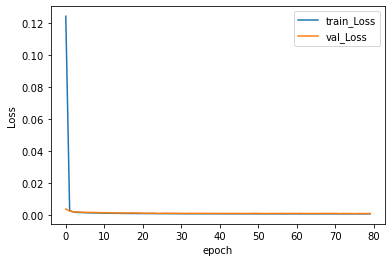

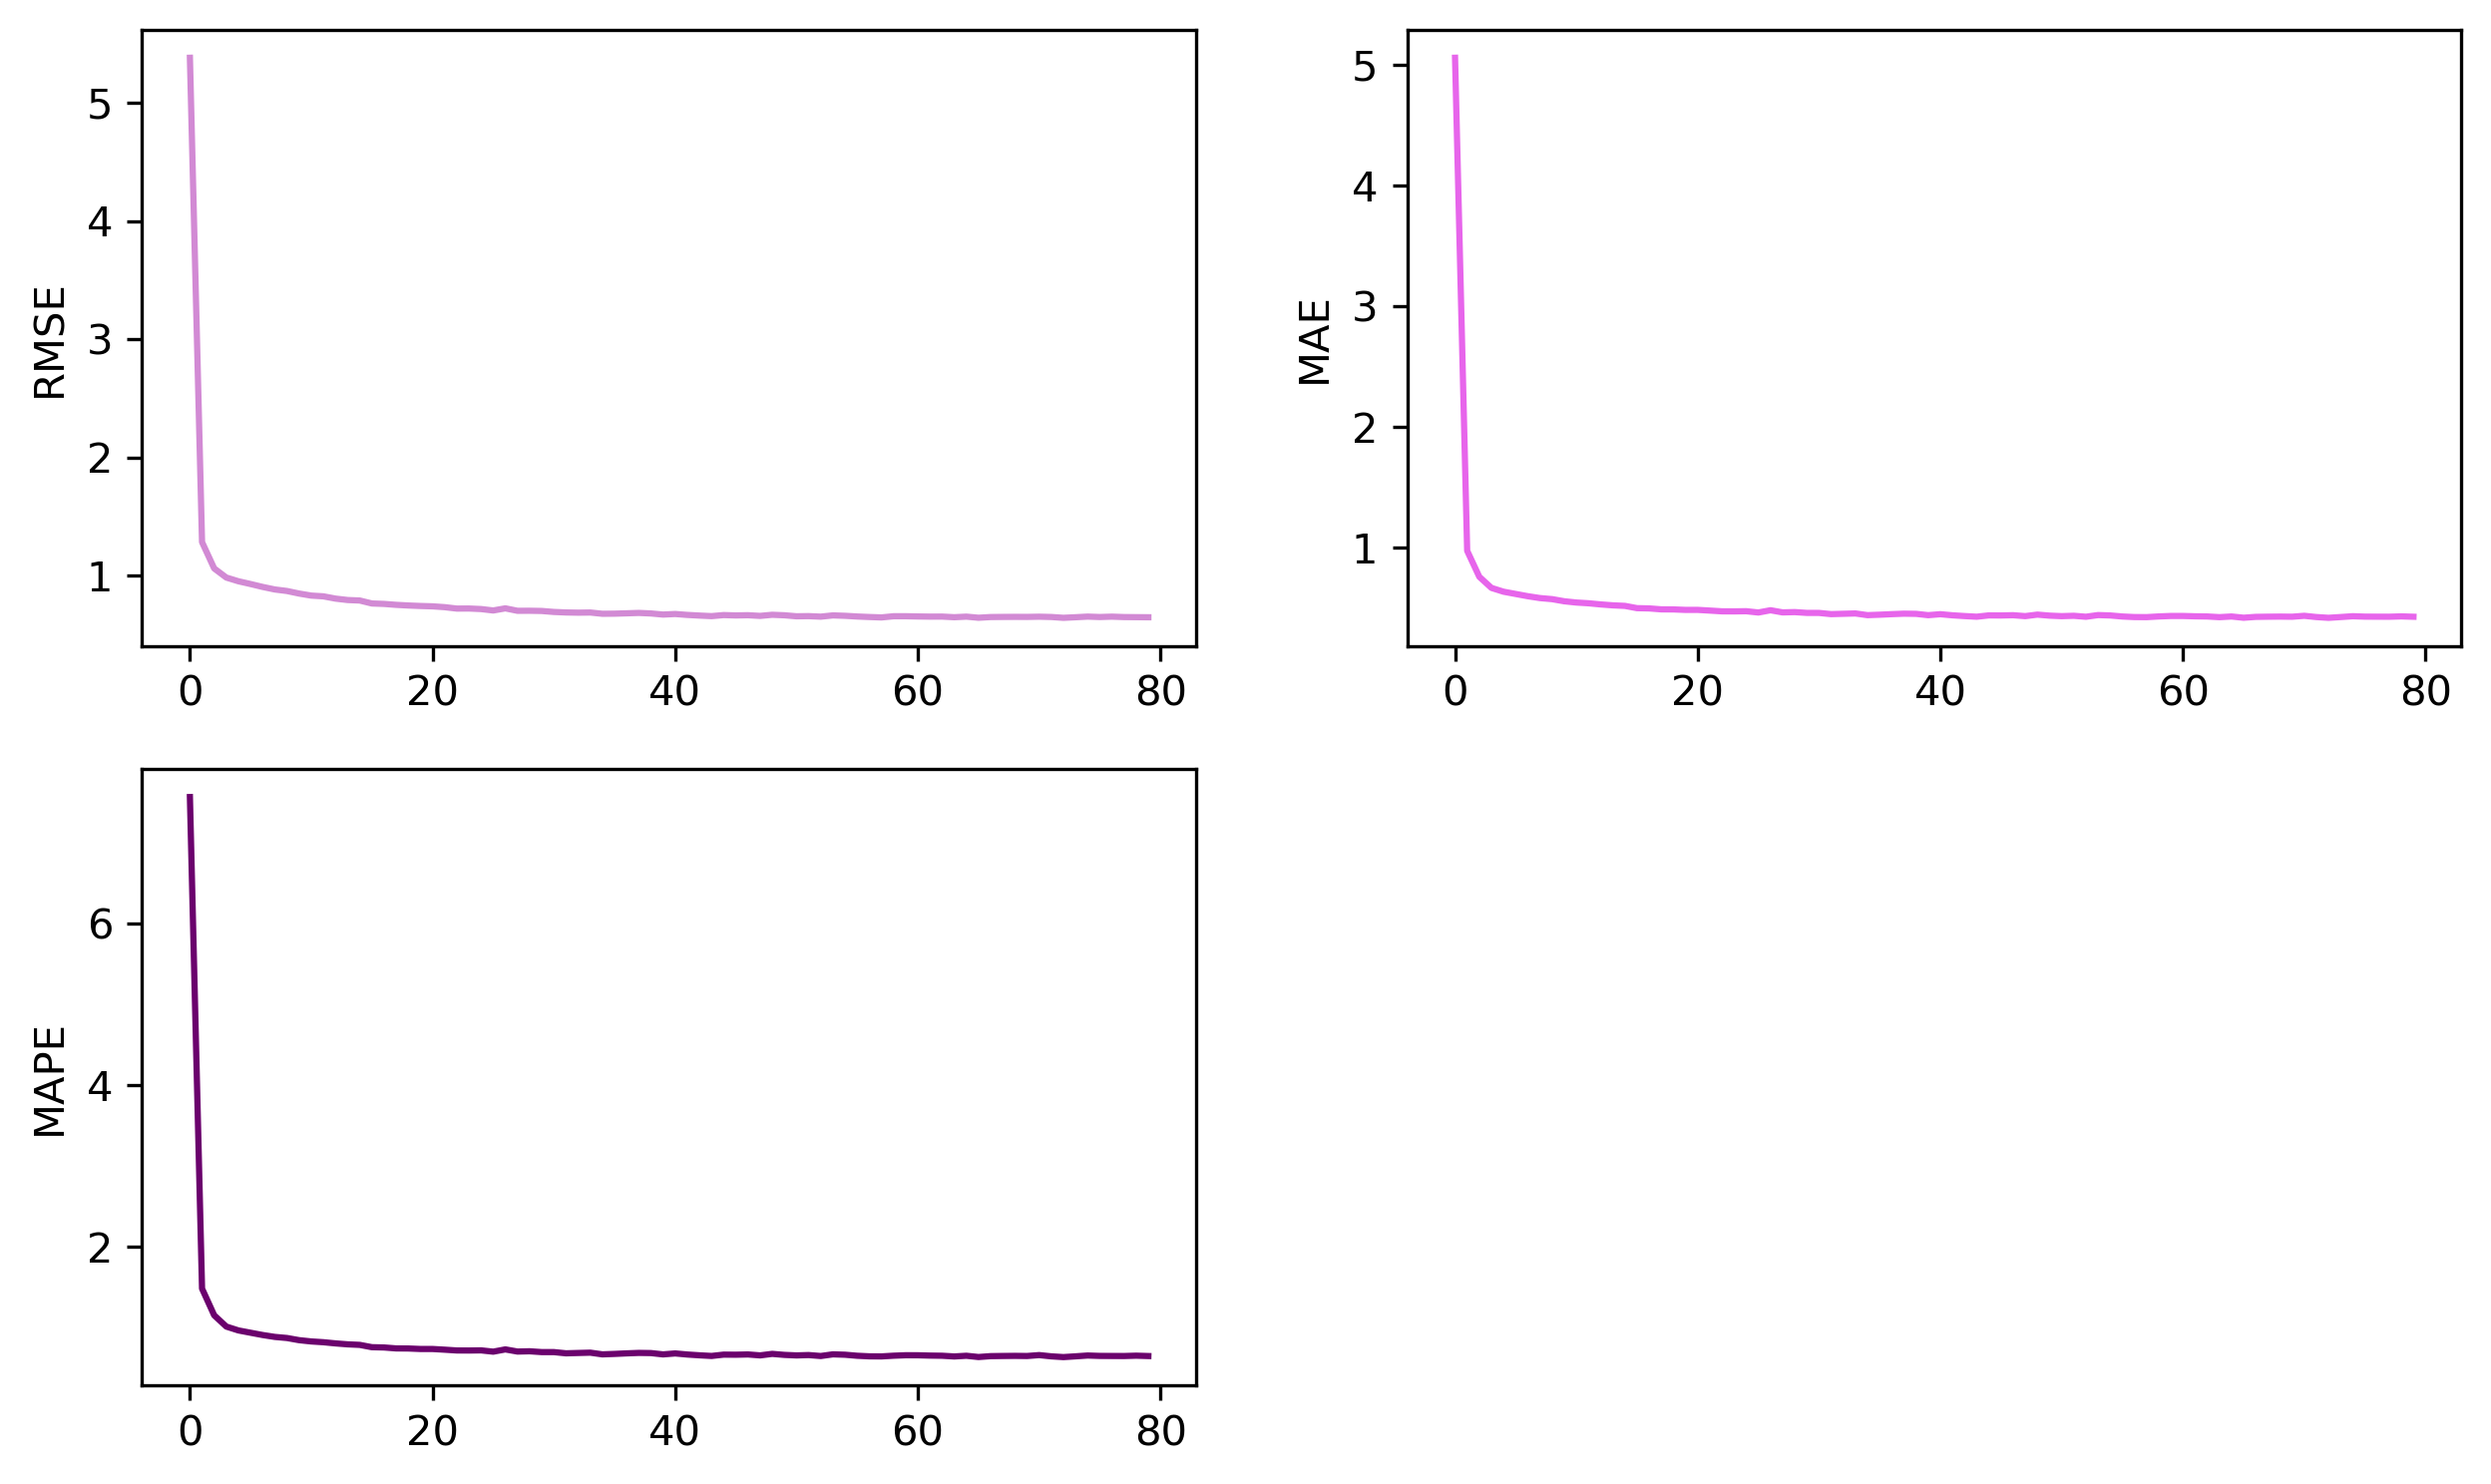

In [17]:
#手动实现RNN

import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########

class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return torch.stack(y_list, dim=1),h


# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 
my_rnn = MyRNN(input_size,hidden_size,output_size).to(device)
optimizer = torch.optim.Adam(my_rnn. parameters(),lr)

train_loss_lst,val_loss_lst,train_score_lst,val_score_lst,stop_epoch = train(my_rnn,train_loader,val_loader,test_loader,loss_func,TrafficData.denormalize,optimizer,epochs,early_stop=20,device=device,output_model=None)
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)


## 2.3.1 实验结果分析
这个实验是采用手动方式实现循环神经网络的实验，一共消耗时间103s。根据实验结果来看，实验的训练损失和测试损失基本接近，无过多出入，三个评价指标也可以看到在MAE评估模型下的数值最小，RMSE和MAPE基本上接近，接下来还需要验证使用调用接口方式下模型的好坏。

*** epoch1, train loss 0.0026, train rmse 1.1963, val loss 0.0021, val rmse 1.066058, time use 1.293s
*** epoch2, train loss 0.0017, train rmse 0.9571, val loss 0.0019, val rmse 1.010121, time use 1.262s
*** epoch3, train loss 0.0015, train rmse 0.8986, val loss 0.0017, val rmse 0.945809, time use 1.260s
*** epoch4, train loss 0.0013, train rmse 0.8556, val loss 0.0016, val rmse 0.909983, time use 1.278s
*** epoch5, train loss 0.0012, train rmse 0.8272, val loss 0.0017, val rmse 0.964817, time use 1.296s
*** epoch6, train loss 0.0012, train rmse 0.8065, val loss 0.0015, val rmse 0.869583, time use 1.323s
*** epoch7, train loss 0.0011, train rmse 0.7829, val loss 0.0014, val rmse 0.841611, time use 1.300s
*** epoch8, train loss 0.0011, train rmse 0.7784, val loss 0.0013, val rmse 0.833361, time use 1.306s
*** epoch9, train loss 0.0011, train rmse 0.7619, val loss 0.0013, val rmse 0.808560, time use 1.340s
*** epoch10, train loss 0.0010, train rmse 0.7417, val loss 0.0013, val rmse 0.799

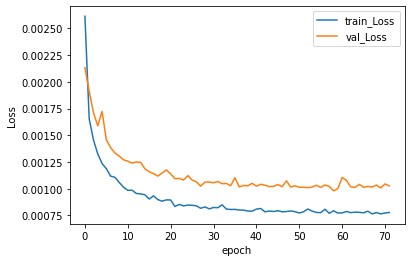

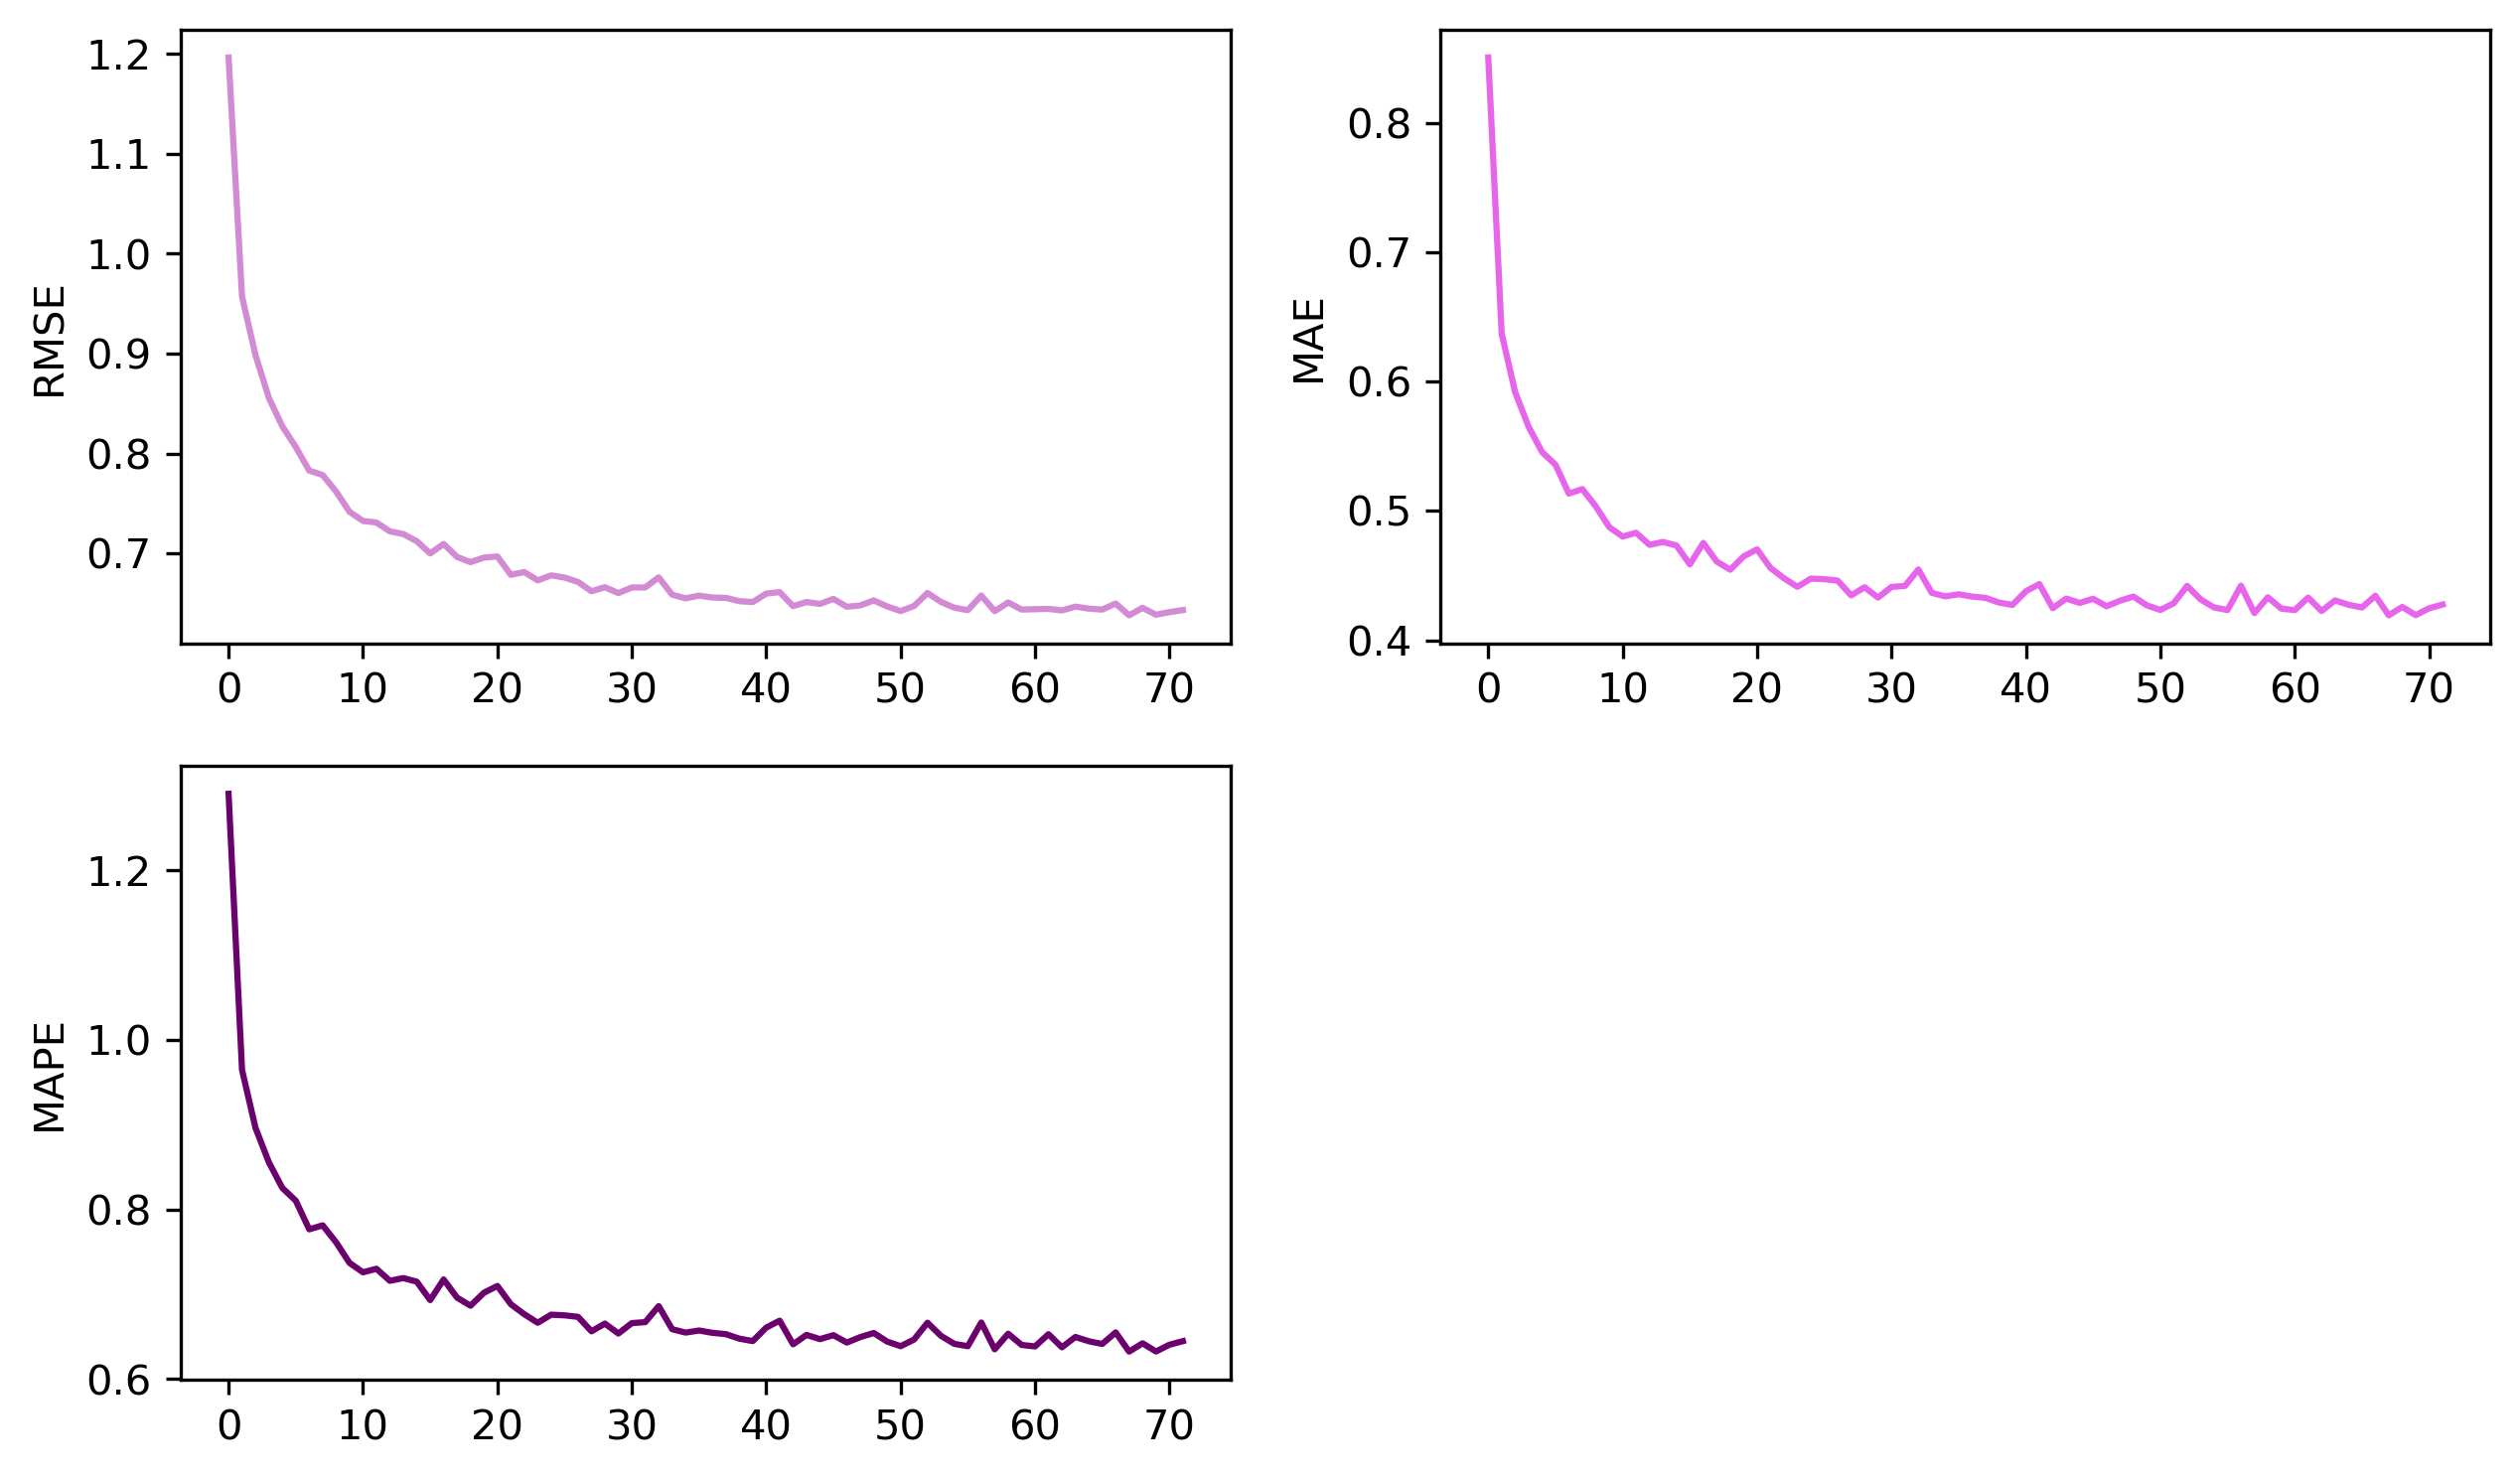

In [28]:
#调用实现RNN

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########

nn_rnn = nn.RNN(input_size=input_size,hidden_size=hidden_size,num_layers=1,batch_first=True). to(device)
out_linear = nn.Sequential(nn.Linear (hidden_size,1),
             nn.LeakyReLU ()).to(device)
optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()),lr)



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 
my_rnn = MyRNN(input_size,hidden_size,output_size).to(device)
optimizer = torch.optim.Adam(my_rnn. parameters(),lr)
train_loss_lst,val_loss_lst,train_score_lst,val_score_lst,stop_epoch = train(my_rnn,train_loader,val_loader,test_loader,loss_func,TrafficData.denormalize,optimizer,epochs,early_stop=20,device=device,output_model=None)
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)



## 2.3.2 实验结果分析
这个实验是采用调用接口的方式实现循环神经网络的实验，一共消耗时间91s。根据实验结果来看，实验的训练损失和测试损失基本接近，与手动实现的基本相近，无过多出入，三个评价指标也可以看到在MAE评估模型下的数值最小，RMSE和MAPE基本上接近，但是总体数值略大于手动实现，模型在70轮时达到了一个较好地训练效果，因此手动实现的模型略差。

*** epoch1, train loss 0.2093, train rmse 10.1662, val loss 0.0059, val rmse 1.843204, time use 2.293s
*** epoch2, train loss 0.0043, train rmse 1.5645, val loss 0.0040, val rmse 1.511322, time use 2.266s
*** epoch3, train loss 0.0035, train rmse 1.4195, val loss 0.0035, val rmse 1.395202, time use 2.170s
*** epoch4, train loss 0.0029, train rmse 1.2956, val loss 0.0028, val rmse 1.269992, time use 2.328s
*** epoch5, train loss 0.0024, train rmse 1.1686, val loss 0.0024, val rmse 1.163748, time use 2.157s
*** epoch6, train loss 0.0020, train rmse 1.0702, val loss 0.0021, val rmse 1.076207, time use 2.308s
*** epoch7, train loss 0.0018, train rmse 1.0089, val loss 0.0020, val rmse 1.051032, time use 2.186s
*** epoch8, train loss 0.0017, train rmse 0.9757, val loss 0.0019, val rmse 1.027482, time use 2.316s
*** epoch9, train loss 0.0016, train rmse 0.9638, val loss 0.0019, val rmse 1.013709, time use 2.240s
*** epoch10, train loss 0.0016, train rmse 0.9486, val loss 0.0018, val rmse 1.00

*** epoch79, train loss 0.0008, train rmse 0.6476, val loss 0.0011, val rmse 0.727162, time use 2.162s
*** epoch80, train loss 0.0008, train rmse 0.6460, val loss 0.0011, val rmse 0.718339, time use 2.153s

****************************************
Final result:
Get best validation rmse 0.7048 at epoch 73
Total time 177.84s

Test result:
Test RMSE: 0.4945708866142185    Test MAE: 0.30112375996329566    Test MAPE: 0.4634765810756521


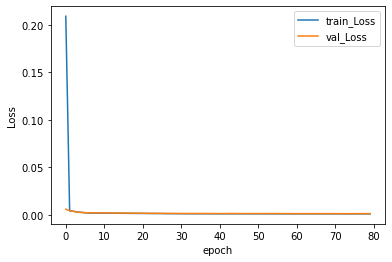

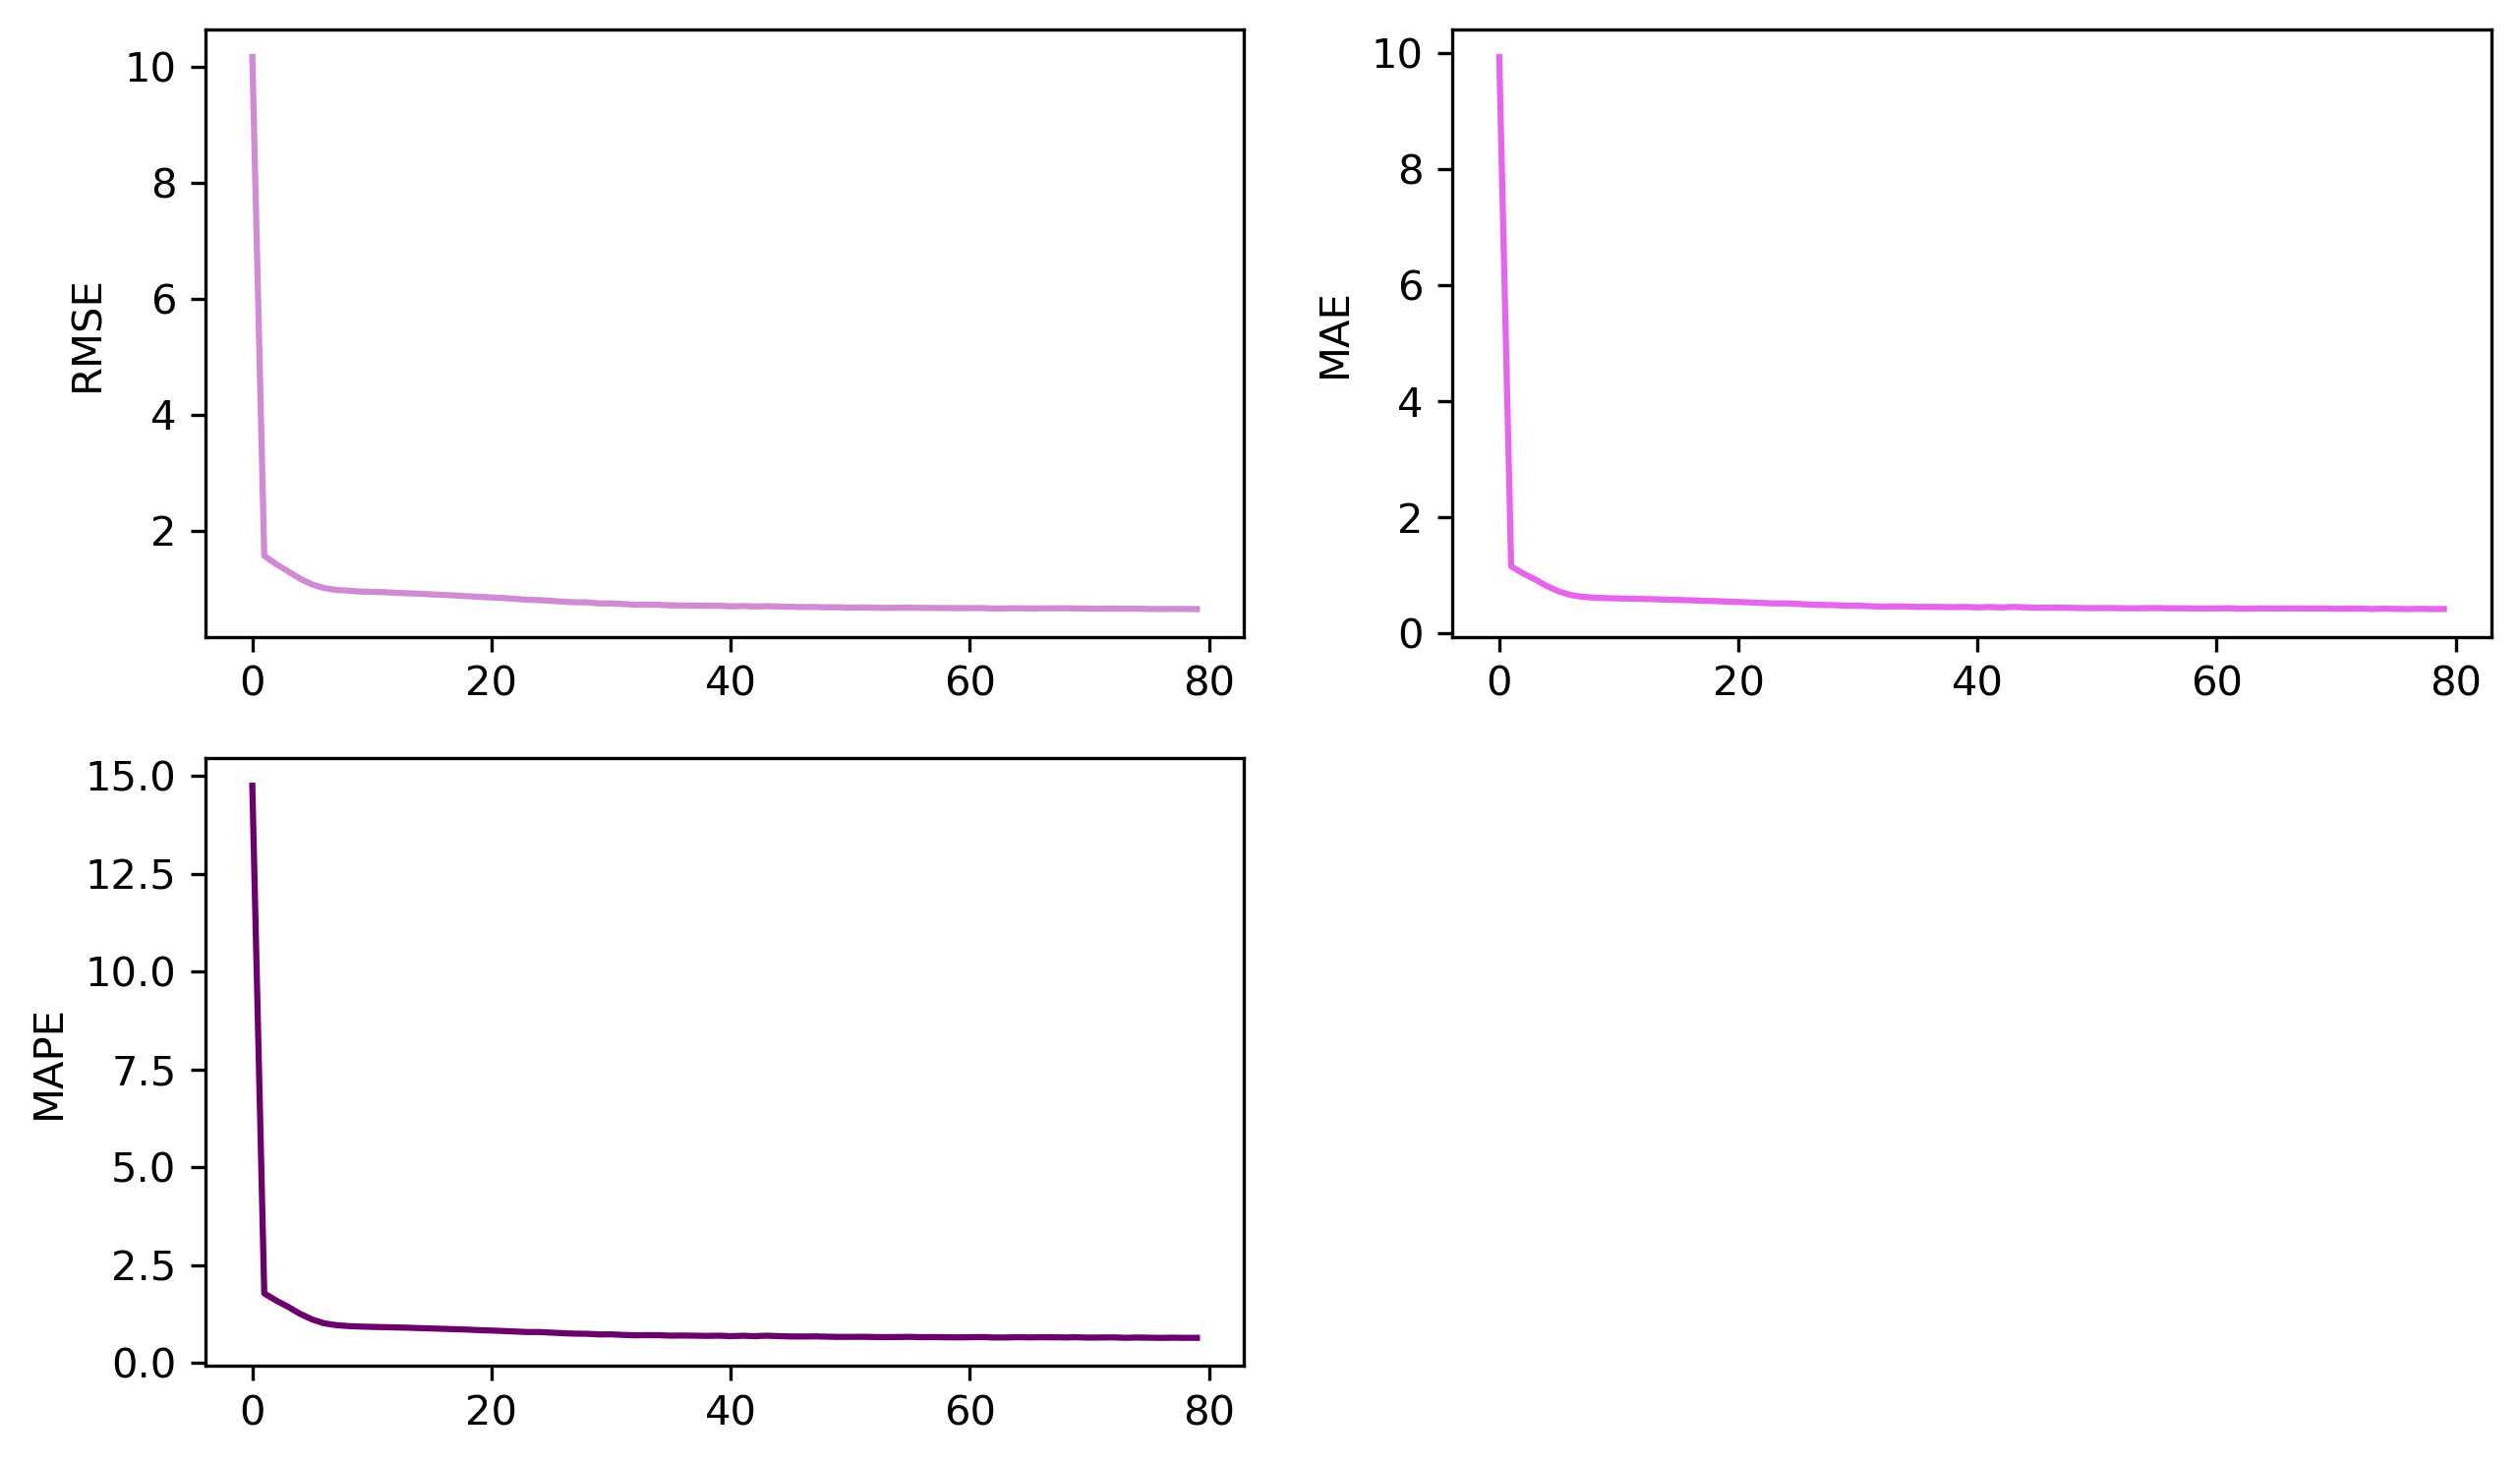

In [20]:
# 手动实现LSTM

import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
#import datasets
#import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)




###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########

class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell =                 self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g)
                                                    for g in (forget_gate, input_gate, output_gate))
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), (h, c)

# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 
my_rnn = My_LSTM(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_rnn. parameters(),lr)

train_loss_lst,val_loss_lst,train_score_lst,val_score_lst,stop_epoch = train(my_rnn,train_loader,val_loader,test_loader,loss_func,TrafficData.denormalize,optimizer,epochs,early_stop=20,device=device,output_model=None)
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)


## 2.3.3 实验结果分析
这个实验是采用手动的方式采用LSTM实现循环神经网络的实验，一共消耗时间177s，消耗时间长是最大的特点。根据实验结果来看，实验的训练损失和测试损失基本接近，和使用卷积神经网络的方法结果基本相似，三个评价指标也可以看到在MSE，RMSE和MAPE基本上接近，但是总体数值略大于，模型没有提前停止，反而在一定的次数达到较好地训练效果。

*** epoch1, train loss 0.5220, train rmse 17.0831, val loss 0.0090, val rmse 2.298647, time use 0.412s
*** epoch2, train loss 0.0036, train rmse 1.4205, val loss 0.0031, val rmse 1.333018, time use 0.408s
*** epoch3, train loss 0.0028, train rmse 1.2662, val loss 0.0029, val rmse 1.279006, time use 0.413s
*** epoch4, train loss 0.0026, train rmse 1.2155, val loss 0.0027, val rmse 1.247725, time use 0.402s
*** epoch5, train loss 0.0024, train rmse 1.1628, val loss 0.0025, val rmse 1.188021, time use 0.404s
*** epoch6, train loss 0.0022, train rmse 1.1189, val loss 0.0023, val rmse 1.148926, time use 0.406s
*** epoch7, train loss 0.0021, train rmse 1.0873, val loss 0.0023, val rmse 1.126415, time use 0.407s
*** epoch8, train loss 0.0020, train rmse 1.0583, val loss 0.0022, val rmse 1.097009, time use 0.410s
*** epoch9, train loss 0.0019, train rmse 1.0437, val loss 0.0021, val rmse 1.092328, time use 0.410s
*** epoch10, train loss 0.0019, train rmse 1.0313, val loss 0.0021, val rmse 1.08

*** epoch79, train loss 0.0009, train rmse 0.6868, val loss 0.0011, val rmse 0.752323, time use 0.504s
*** epoch80, train loss 0.0009, train rmse 0.6803, val loss 0.0012, val rmse 0.776126, time use 0.450s

****************************************
Final result:
Get best validation rmse 0.7523 at epoch 78
Total time 34.23s

Test result:
Test RMSE: 0.5499446167972094    Test MAE: 0.35347805239937524    Test MAPE: 0.5411732785234397


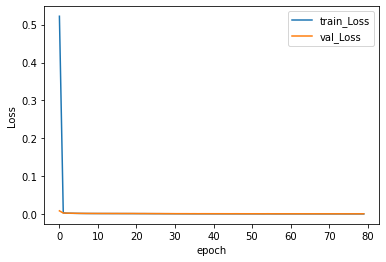

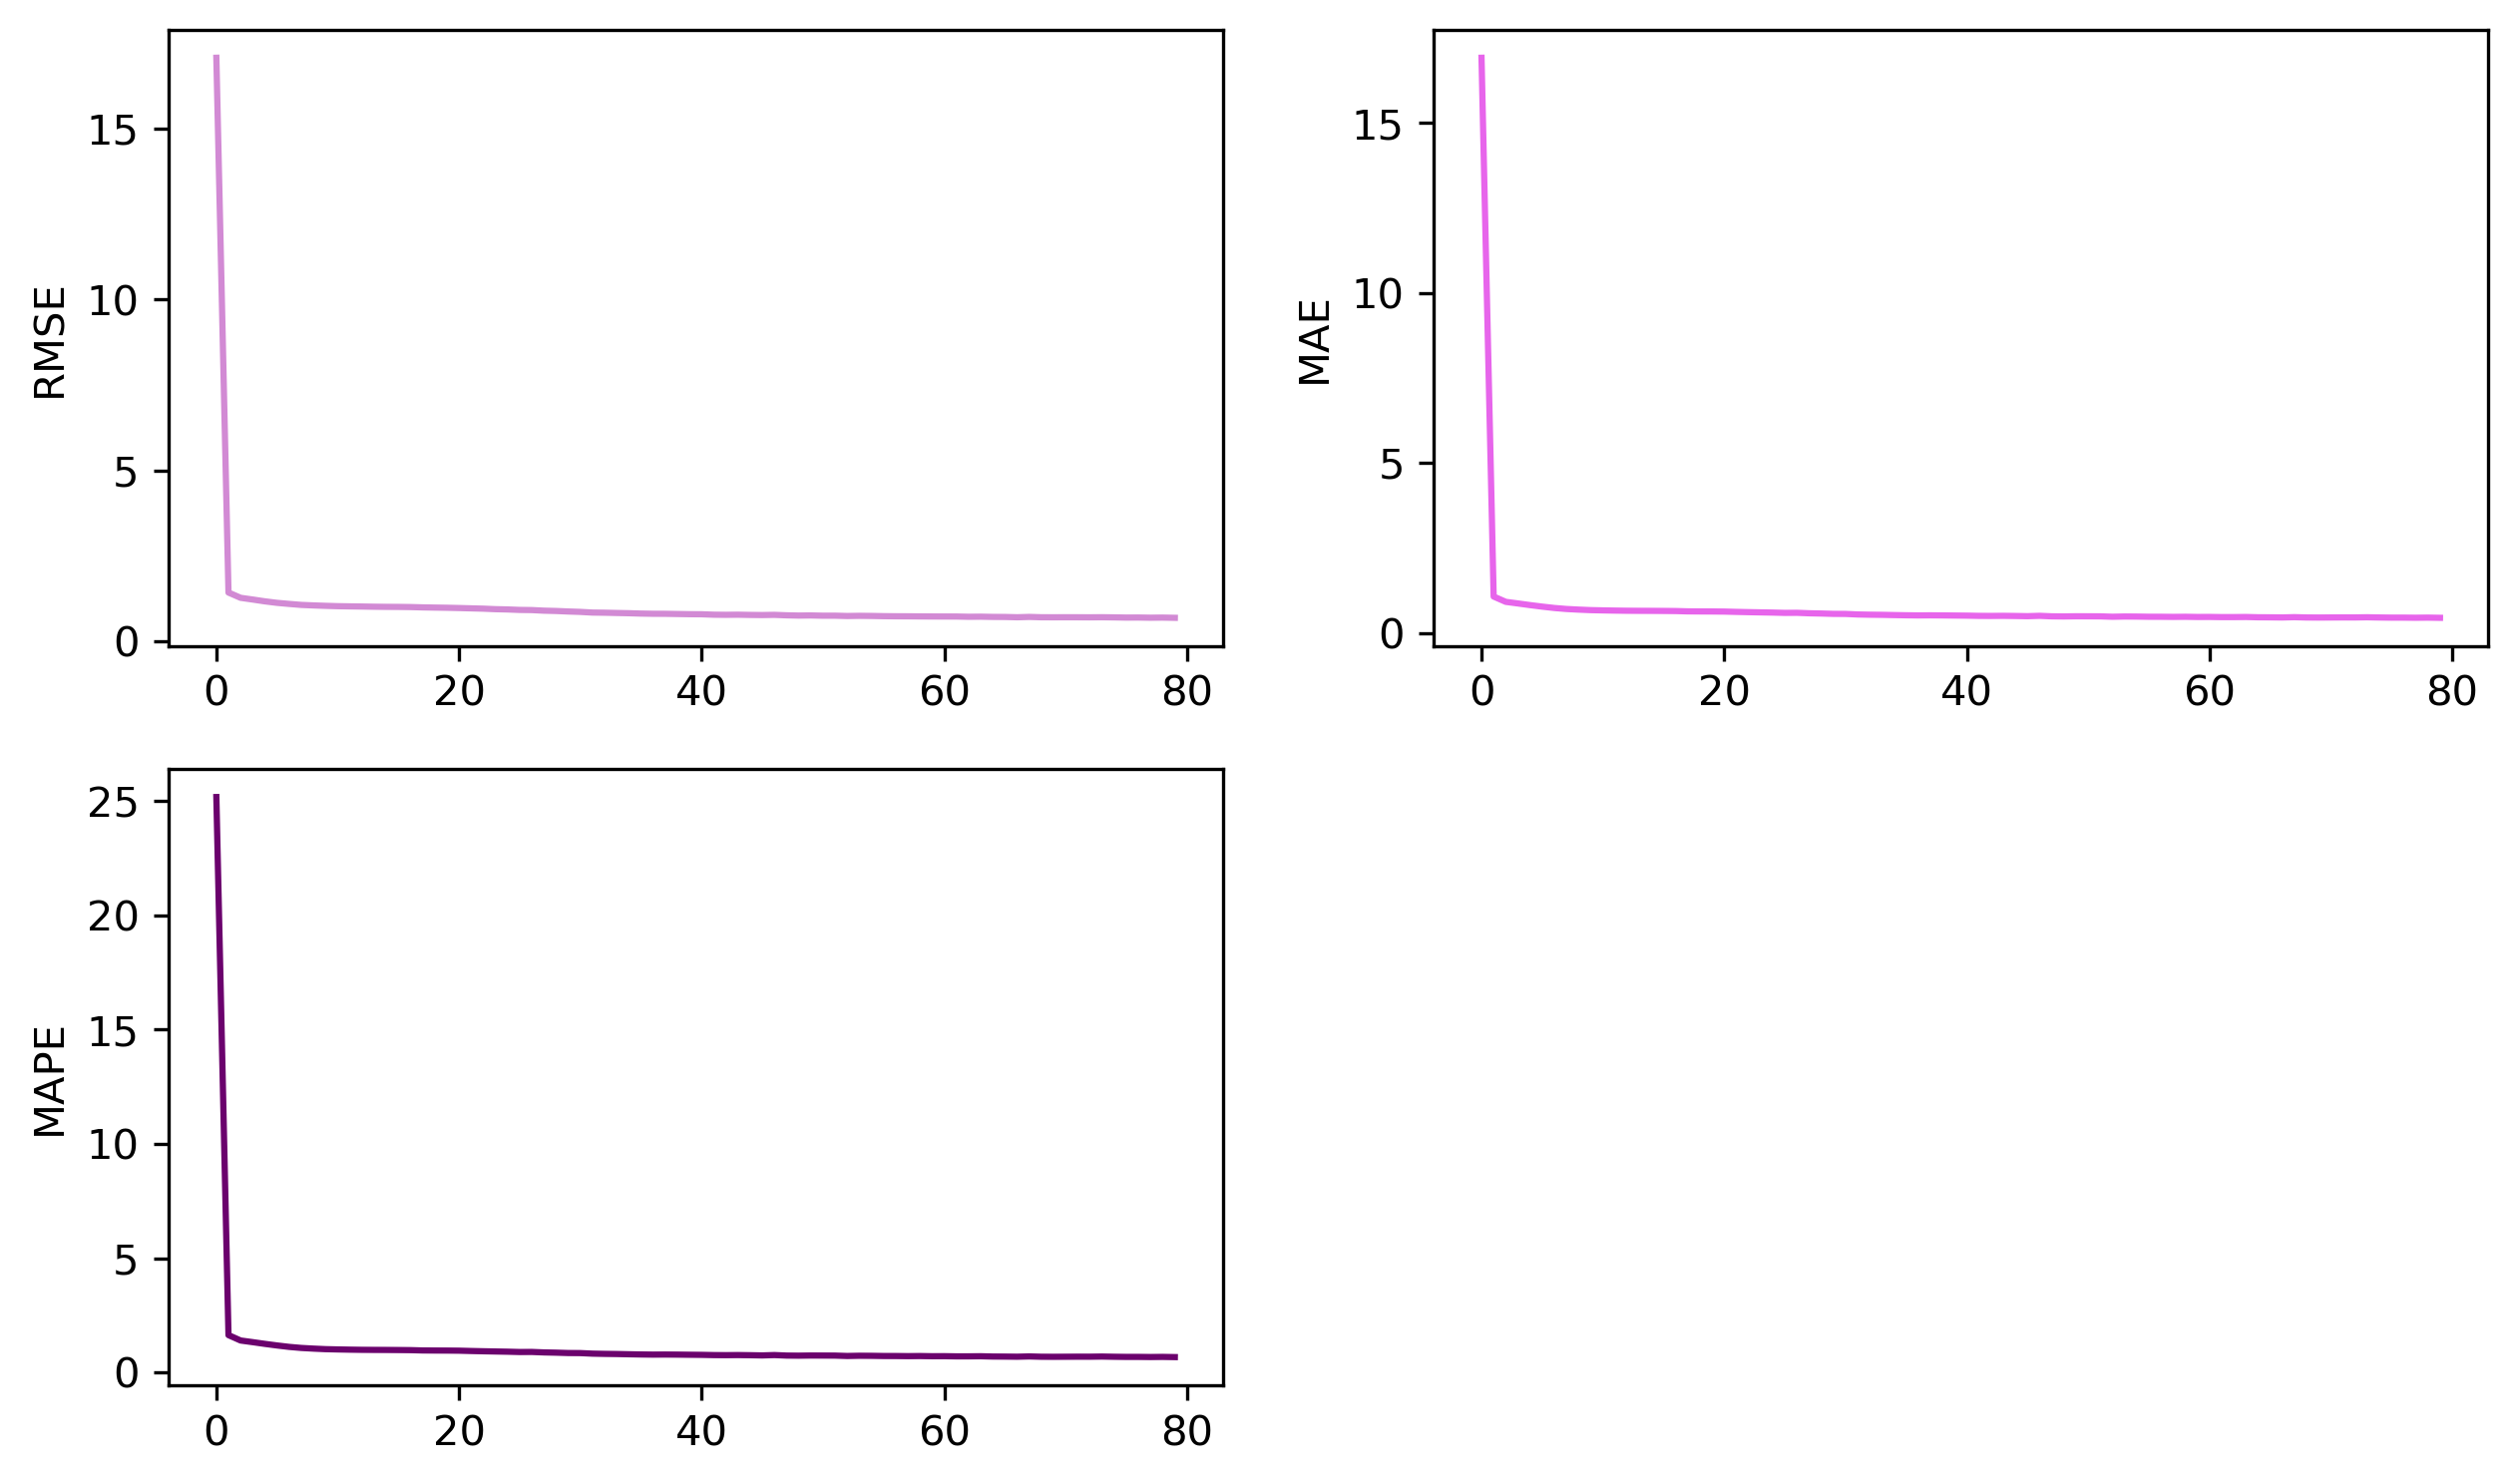

In [21]:
# 调用实现LSTM

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst,     train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)


visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)




## 2.3.4 实验结果分析
这个实验是采用调用接口的方式采用LSTM实现循环神经网络的实验，一共消耗时间34s，消耗时间短是最大的特点，因为调用自带接口省去了许多自定义时不必要的麻烦。根据实验结果来看，实验的训练损失和测试损失基本接近，和使用卷积神经网络的方法结果基本相似，但是略有较小毛刺，三个评价指标也可以看到在MSE，RMSE和MAPE基本上接近，但是总体数值更小，模型没有提前停止，在一定的次数达到较好地训练效果。可以认定接口实现的效果好。

*** epoch1, train loss 0.1660, train rmse 7.9845, val loss 0.0052, val rmse 1.709620, time use 2.185s
*** epoch2, train loss 0.0047, train rmse 1.6425, val loss 0.0045, val rmse 1.608752, time use 2.146s
*** epoch3, train loss 0.0039, train rmse 1.4991, val loss 0.0037, val rmse 1.448060, time use 2.082s
*** epoch4, train loss 0.0032, train rmse 1.3455, val loss 0.0031, val rmse 1.327640, time use 2.055s
*** epoch5, train loss 0.0025, train rmse 1.1896, val loss 0.0025, val rmse 1.168654, time use 1.988s
*** epoch6, train loss 0.0020, train rmse 1.0692, val loss 0.0021, val rmse 1.075338, time use 2.016s
*** epoch7, train loss 0.0017, train rmse 0.9971, val loss 0.0020, val rmse 1.060176, time use 2.295s
*** epoch8, train loss 0.0017, train rmse 0.9728, val loss 0.0019, val rmse 1.019797, time use 2.142s
*** epoch9, train loss 0.0016, train rmse 0.9513, val loss 0.0018, val rmse 0.992120, time use 2.138s
*** epoch10, train loss 0.0015, train rmse 0.9351, val loss 0.0018, val rmse 0.984

*** epoch79, train loss 0.0008, train rmse 0.6430, val loss 0.0011, val rmse 0.714207, time use 2.017s
*** epoch80, train loss 0.0008, train rmse 0.6489, val loss 0.0011, val rmse 0.709089, time use 2.053s

****************************************
Final result:
Get best validation rmse 0.7017 at epoch 72
Total time 169.34s

Test result:
Test RMSE: 0.48447982170744464    Test MAE: 0.29219346913424404    Test MAPE: 0.44896261470223015


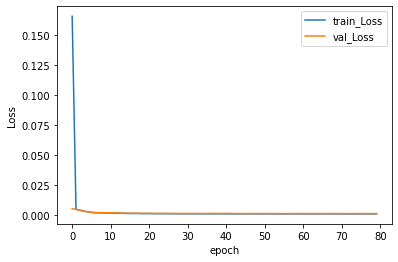

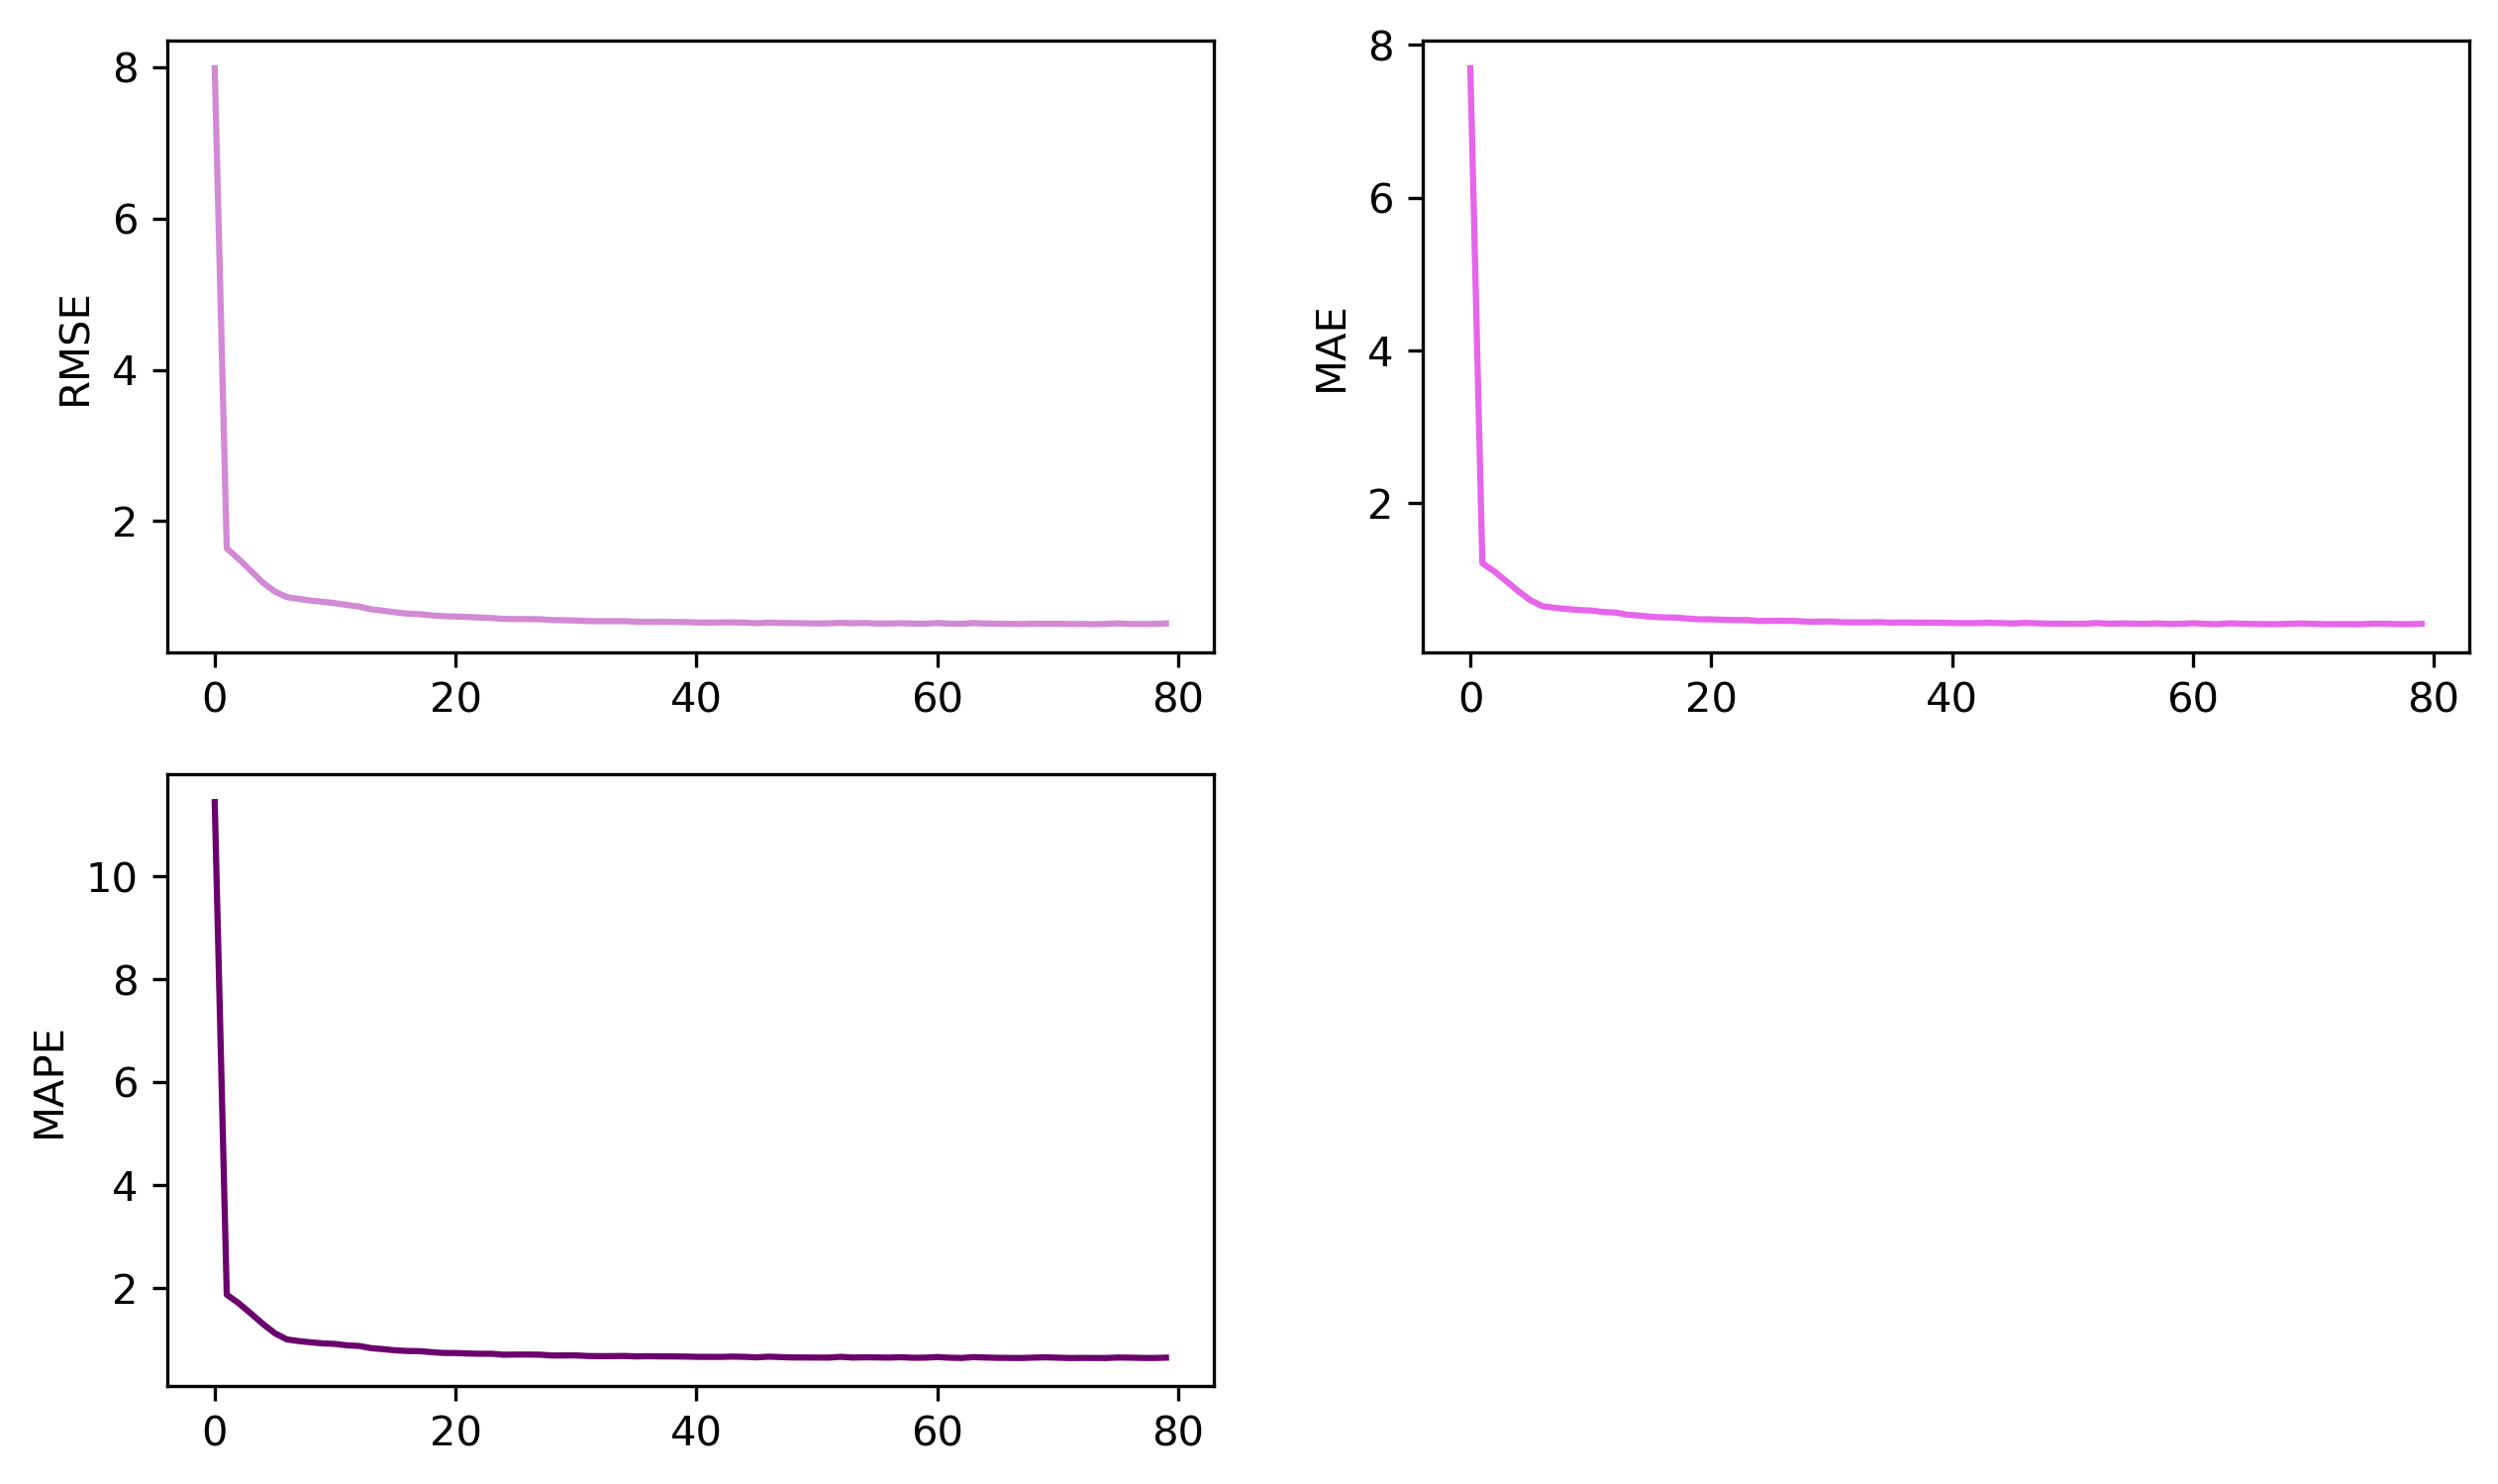

In [22]:
# 手动实现GRU

import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
#import datasets
#import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)




###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########

class MyGRU(nn. Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h = torch.zeros(batch_size, self.hidden_size).to(x.device) 
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell =                 self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g)
                                                    for g in (forget_gate, input_gate, output_gate))
           
            h = (1-forget_gate)*h+forget_gate*candidate_cell
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1),h

# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 
my_rnn = MyGRU(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_rnn. parameters(),lr)

train_loss_lst,val_loss_lst,train_score_lst,val_score_lst,stop_epoch = train(my_rnn,train_loader,val_loader,test_loader,loss_func,TrafficData.denormalize,optimizer,epochs,early_stop=20,device=device,output_model=None)
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)


## 2.3.5 实验结果分析
这个实验是采用手动的方式采用GRU实现循环神经网络的实验，一共消耗时间169s，消耗时间略短于LSTM网络。根据实验结果来看，实验的训练损失和测试损失基本接近，和使用卷积神经网络的方法结果基本相似，三个评价指标也可以看到在MSE，MAPE基本上接近，模型没有提前停止，在一定的次数达到较好地训练效果，总体看略慢于LSTM网络。

*** epoch1, train loss 0.3174, train rmse 13.0622, val loss 0.0306, val rmse 4.249986, time use 0.454s
*** epoch2, train loss 0.0054, train rmse 1.6969, val loss 0.0042, val rmse 1.543354, time use 0.483s
*** epoch3, train loss 0.0038, train rmse 1.4838, val loss 0.0039, val rmse 1.500335, time use 0.512s
*** epoch4, train loss 0.0035, train rmse 1.4268, val loss 0.0036, val rmse 1.427259, time use 0.449s
*** epoch5, train loss 0.0032, train rmse 1.3573, val loss 0.0033, val rmse 1.366182, time use 0.454s
*** epoch6, train loss 0.0029, train rmse 1.2812, val loss 0.0029, val rmse 1.274008, time use 0.425s
*** epoch7, train loss 0.0025, train rmse 1.1999, val loss 0.0026, val rmse 1.207816, time use 0.437s
*** epoch8, train loss 0.0022, train rmse 1.1188, val loss 0.0023, val rmse 1.133215, time use 0.425s
*** epoch9, train loss 0.0019, train rmse 1.0514, val loss 0.0021, val rmse 1.088711, time use 0.427s
*** epoch10, train loss 0.0018, train rmse 1.0008, val loss 0.0019, val rmse 1.04

*** epoch79, train loss 0.0008, train rmse 0.6500, val loss 0.0011, val rmse 0.730752, time use 0.399s
*** epoch80, train loss 0.0008, train rmse 0.6533, val loss 0.0010, val rmse 0.706461, time use 0.494s

****************************************
Final result:
Get best validation rmse 0.7065 at epoch 79
Total time 34.15s

Test result:
Test RMSE: 0.5116981601504041    Test MAE: 0.31484431570226495    Test MAPE: 0.4852288364517418


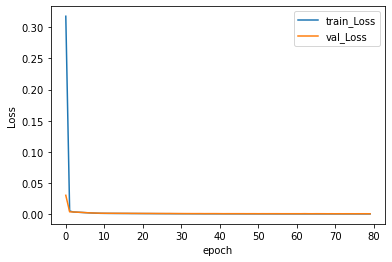

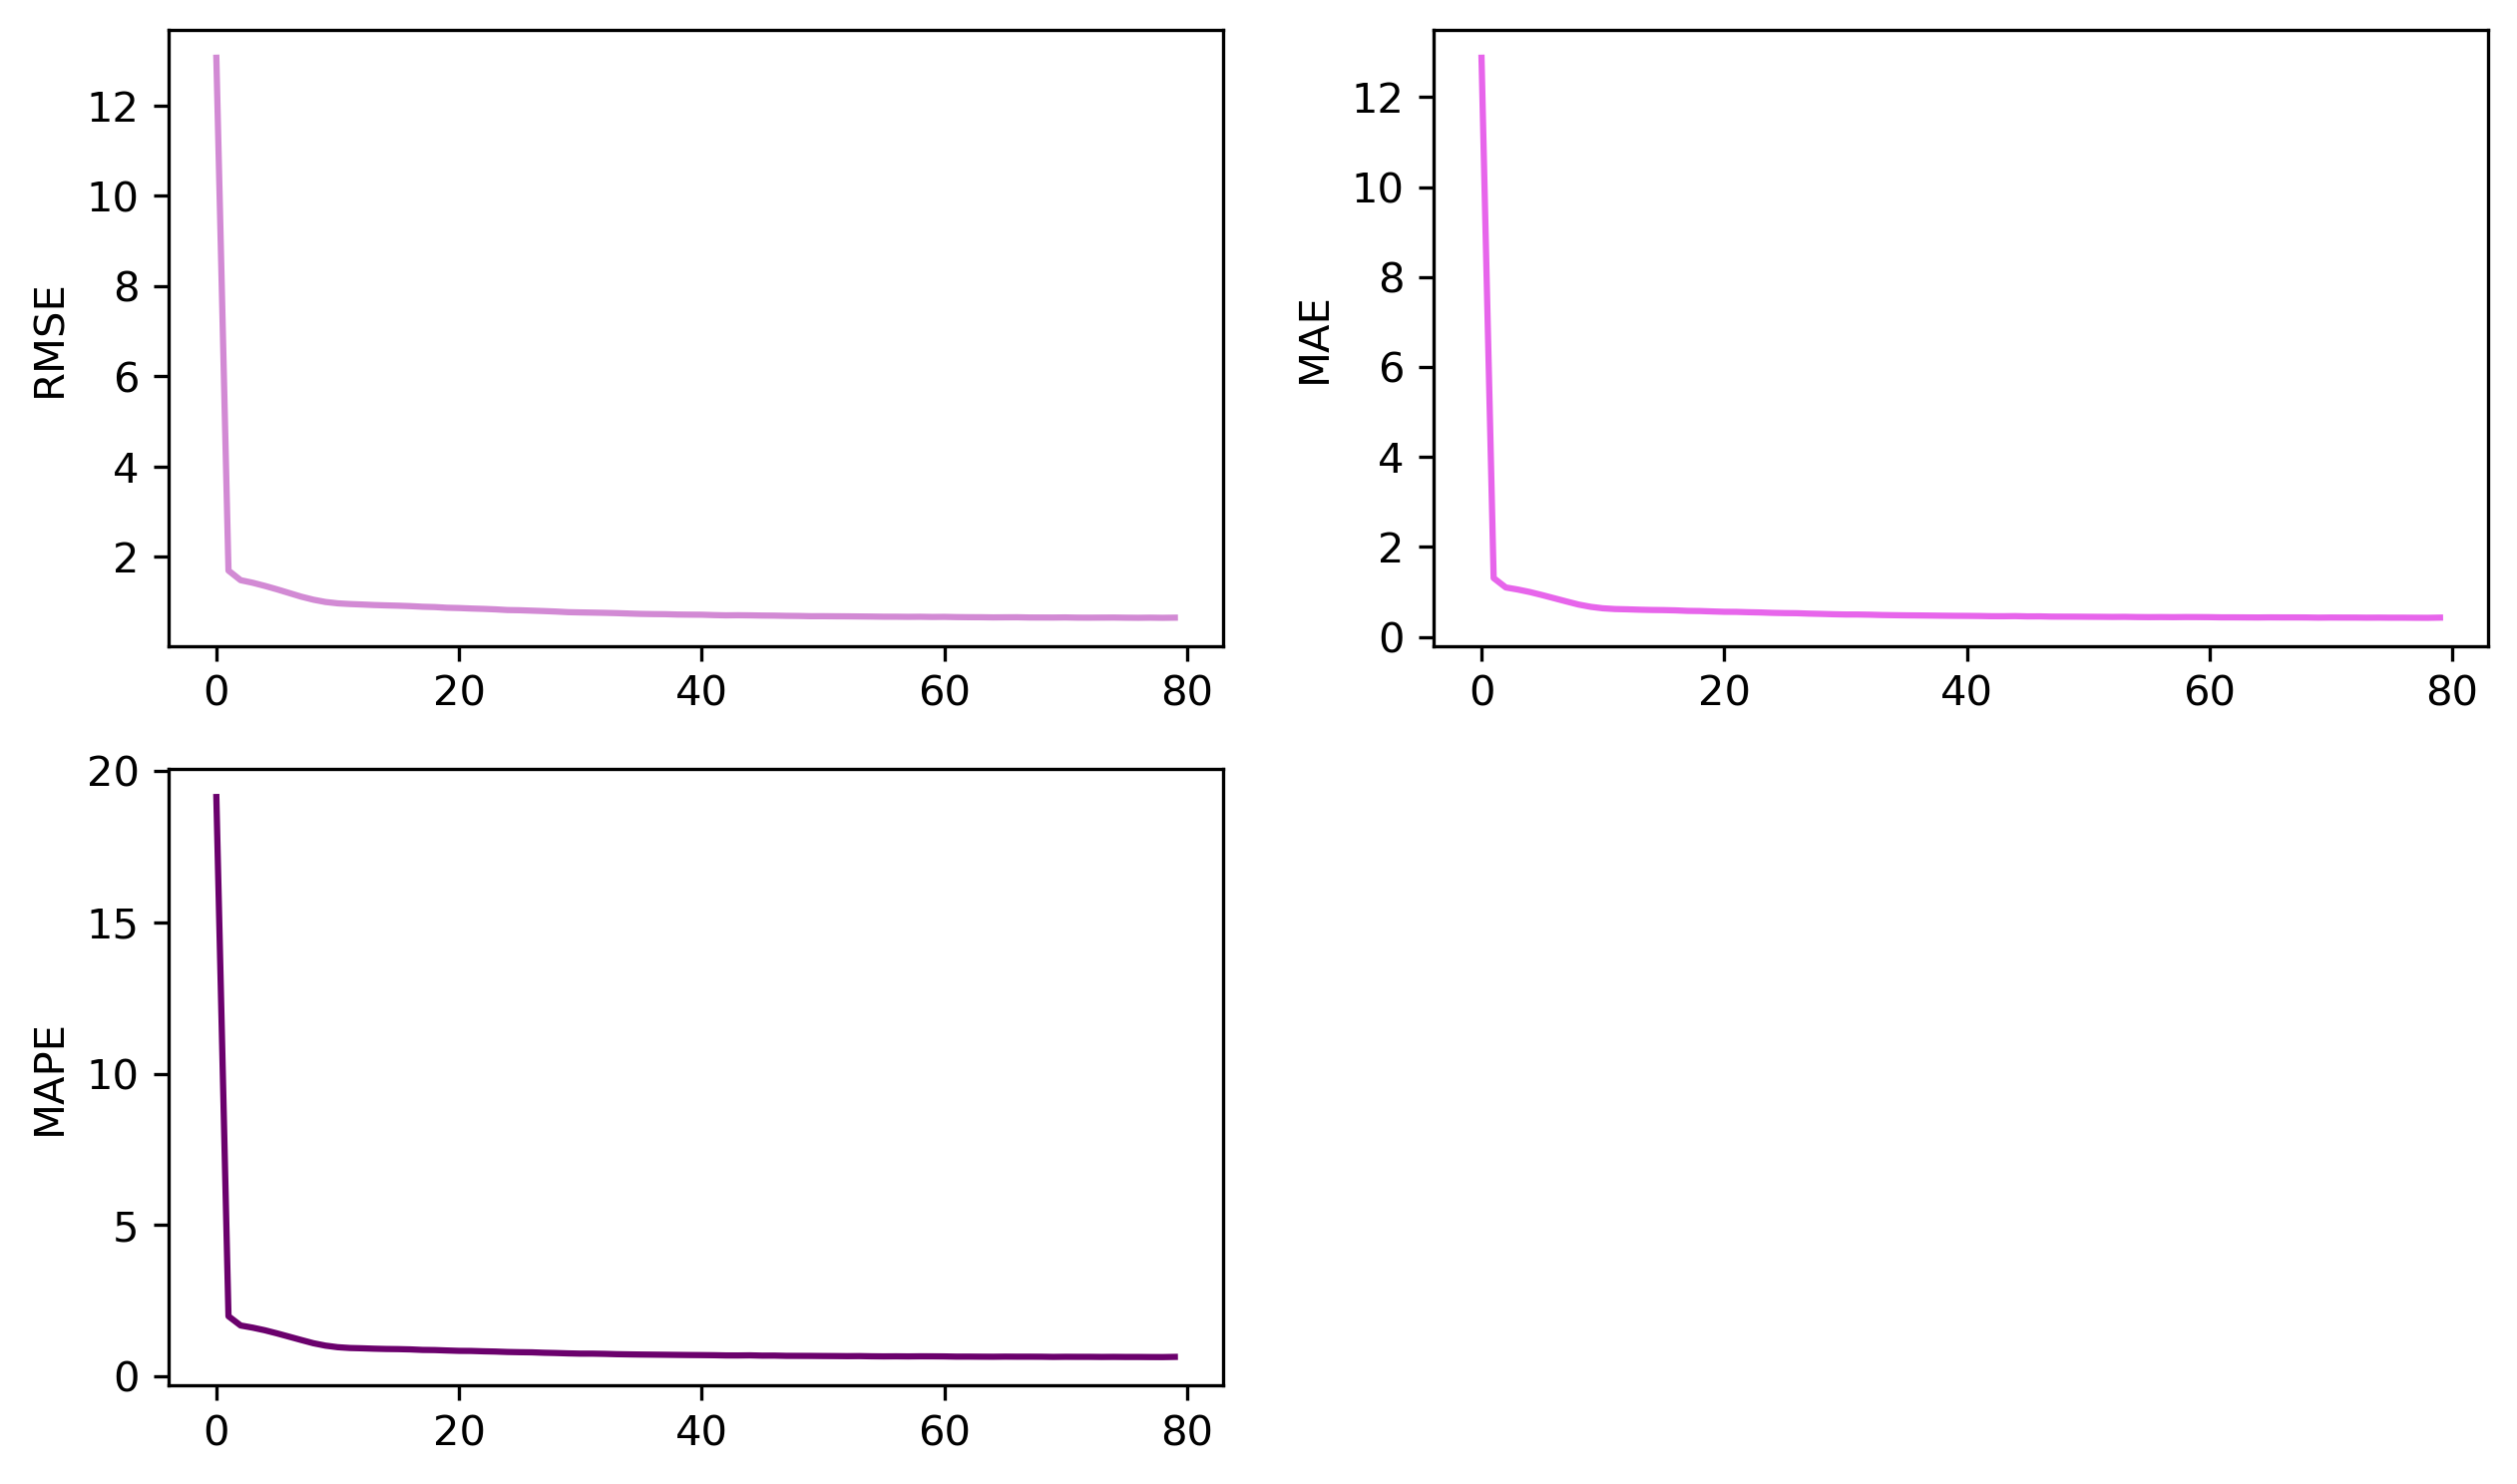

In [23]:
# 调用实现GRU

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 

nn_rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst,     train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)


visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)


## 2.3.6 实验结果分析
这个实验是采用调用接口的方式采用GRU实现循环神经网络的实验，一共消耗时间34s，消耗时间短是最大的特点，因为调用自带接口省去了许多自定义时不必要的麻烦。根据实验结果来看，实验的训练损失和测试损失基本接近，和使用卷积神经网络的方法结果基本相似，损失也更加平滑，实验效果也相对更好，三个评价指标也可以看到在MSE，RMSE和MAPE基本上比较小，但是总体数值更小，在79轮次数达到最佳训练效果。可以认定接口实现的效果好。

---

# 三、对比循环神经网络

## 3.1 任务内容

1. 任务具体要求
    1. 从训练时间、预测精度、Loss变化等角度对比分析RNN、LSTM和GRU在相同数据集上的实验结果（最好使用图表展示）
2. 任务目的
    1. 分析不同循环神经网络的区别
4. 任务所用数据集
    1. 高速公路车流量数据

## 3.2 任务思路及代码

1. 导入数据（训练集和测试集）
2. 建立对应神经网络（RNN，LSTM，GRU）
3. 将数据放入求解器进行训练
4. 分析结果

*** epoch1, train loss 0.0026, train rmse 1.1963, val loss 0.0021, val rmse 1.066058, time use 1.293s
*** epoch2, train loss 0.0017, train rmse 0.9571, val loss 0.0019, val rmse 1.010121, time use 1.262s
*** epoch3, train loss 0.0015, train rmse 0.8986, val loss 0.0017, val rmse 0.945809, time use 1.260s
*** epoch4, train loss 0.0013, train rmse 0.8556, val loss 0.0016, val rmse 0.909983, time use 1.278s
*** epoch5, train loss 0.0012, train rmse 0.8272, val loss 0.0017, val rmse 0.964817, time use 1.296s
*** epoch6, train loss 0.0012, train rmse 0.8065, val loss 0.0015, val rmse 0.869583, time use 1.323s
*** epoch7, train loss 0.0011, train rmse 0.7829, val loss 0.0014, val rmse 0.841611, time use 1.300s
*** epoch8, train loss 0.0011, train rmse 0.7784, val loss 0.0013, val rmse 0.833361, time use 1.306s
*** epoch9, train loss 0.0011, train rmse 0.7619, val loss 0.0013, val rmse 0.808560, time use 1.340s
*** epoch10, train loss 0.0010, train rmse 0.7417, val loss 0.0013, val rmse 0.799

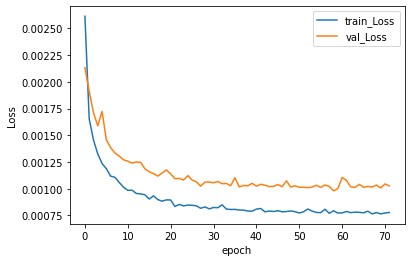

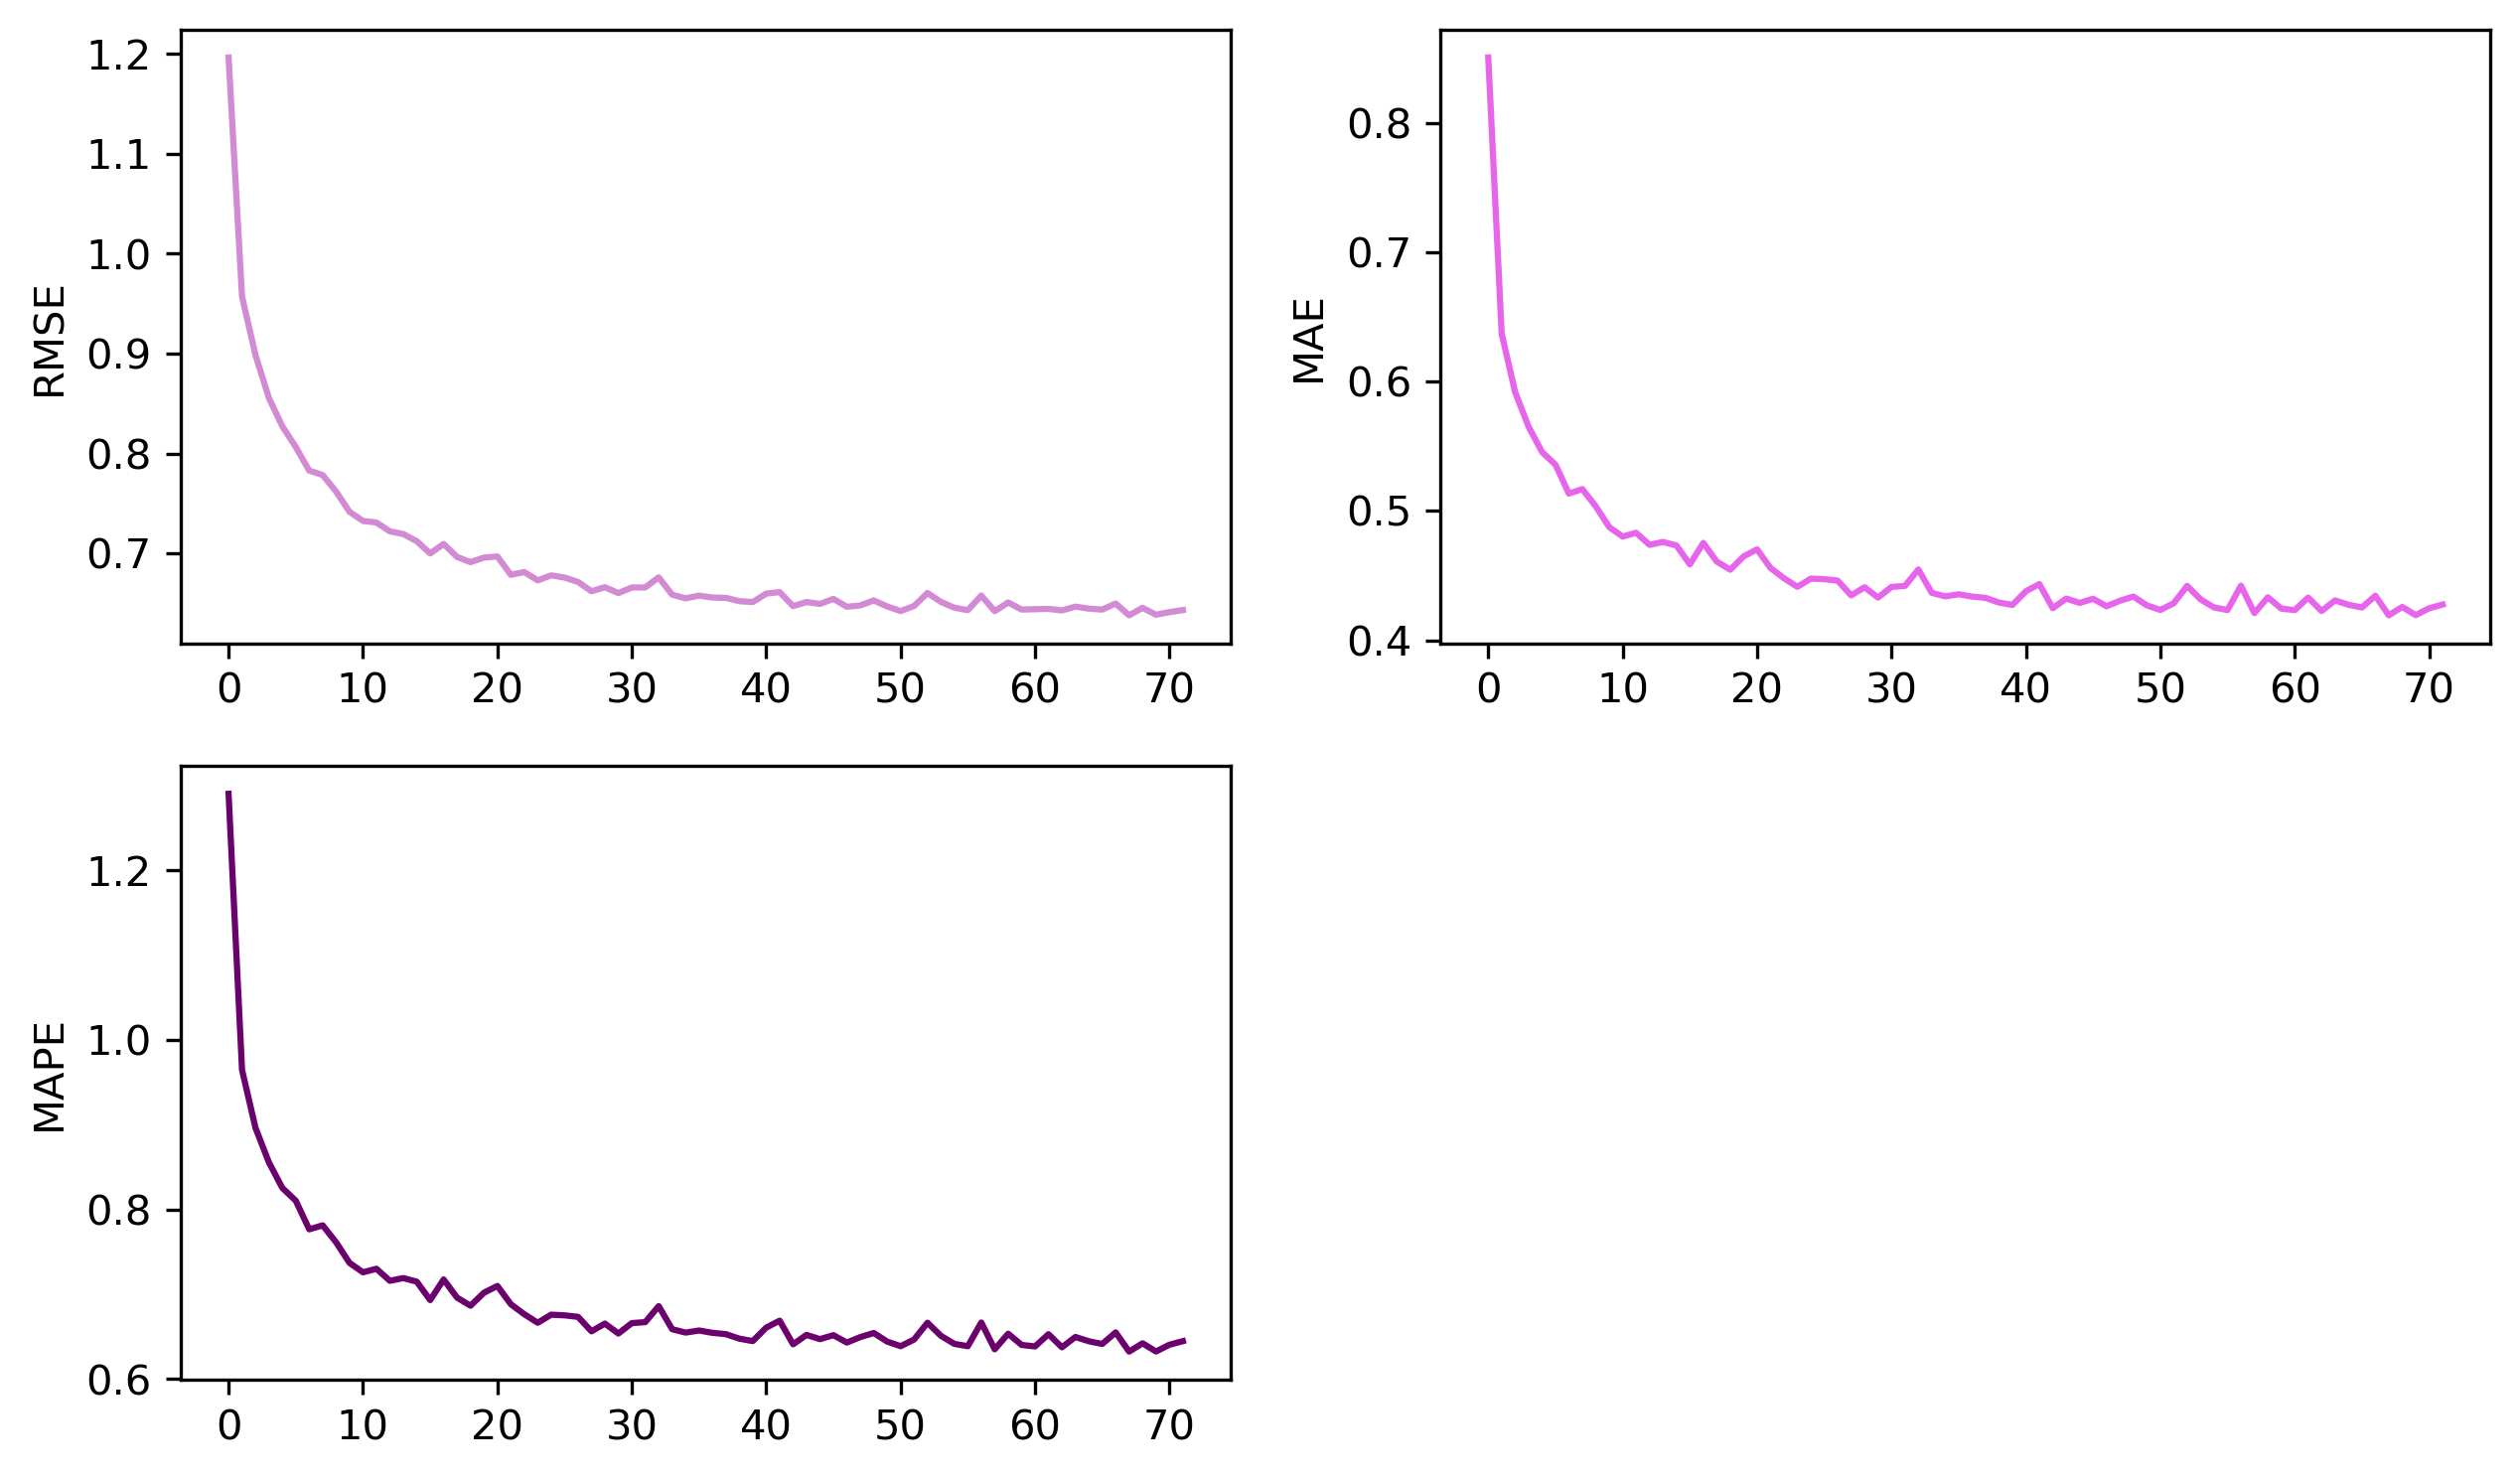

In [28]:
#调用实现RNN

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########

nn_rnn = nn.RNN(input_size=input_size,hidden_size=hidden_size,num_layers=1,batch_first=True). to(device)
out_linear = nn.Sequential(nn.Linear (hidden_size,1),
             nn.LeakyReLU ()).to(device)
optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()),lr)



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 
my_rnn = MyRNN(input_size,hidden_size,output_size).to(device)
optimizer = torch.optim.Adam(my_rnn. parameters(),lr)
train_loss_lst,val_loss_lst,train_score_lst,val_score_lst,stop_epoch = train(my_rnn,train_loader,val_loader,test_loader,loss_func,TrafficData.denormalize,optimizer,epochs,early_stop=20,device=device,output_model=None)
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)



*** epoch1, train loss 0.5220, train rmse 17.0831, val loss 0.0090, val rmse 2.298647, time use 0.412s
*** epoch2, train loss 0.0036, train rmse 1.4205, val loss 0.0031, val rmse 1.333018, time use 0.408s
*** epoch3, train loss 0.0028, train rmse 1.2662, val loss 0.0029, val rmse 1.279006, time use 0.413s
*** epoch4, train loss 0.0026, train rmse 1.2155, val loss 0.0027, val rmse 1.247725, time use 0.402s
*** epoch5, train loss 0.0024, train rmse 1.1628, val loss 0.0025, val rmse 1.188021, time use 0.404s
*** epoch6, train loss 0.0022, train rmse 1.1189, val loss 0.0023, val rmse 1.148926, time use 0.406s
*** epoch7, train loss 0.0021, train rmse 1.0873, val loss 0.0023, val rmse 1.126415, time use 0.407s
*** epoch8, train loss 0.0020, train rmse 1.0583, val loss 0.0022, val rmse 1.097009, time use 0.410s
*** epoch9, train loss 0.0019, train rmse 1.0437, val loss 0.0021, val rmse 1.092328, time use 0.410s
*** epoch10, train loss 0.0019, train rmse 1.0313, val loss 0.0021, val rmse 1.08

*** epoch79, train loss 0.0009, train rmse 0.6868, val loss 0.0011, val rmse 0.752323, time use 0.504s
*** epoch80, train loss 0.0009, train rmse 0.6803, val loss 0.0012, val rmse 0.776126, time use 0.450s

****************************************
Final result:
Get best validation rmse 0.7523 at epoch 78
Total time 34.23s

Test result:
Test RMSE: 0.5499446167972094    Test MAE: 0.35347805239937524    Test MAPE: 0.5411732785234397


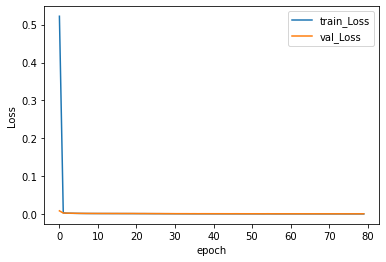

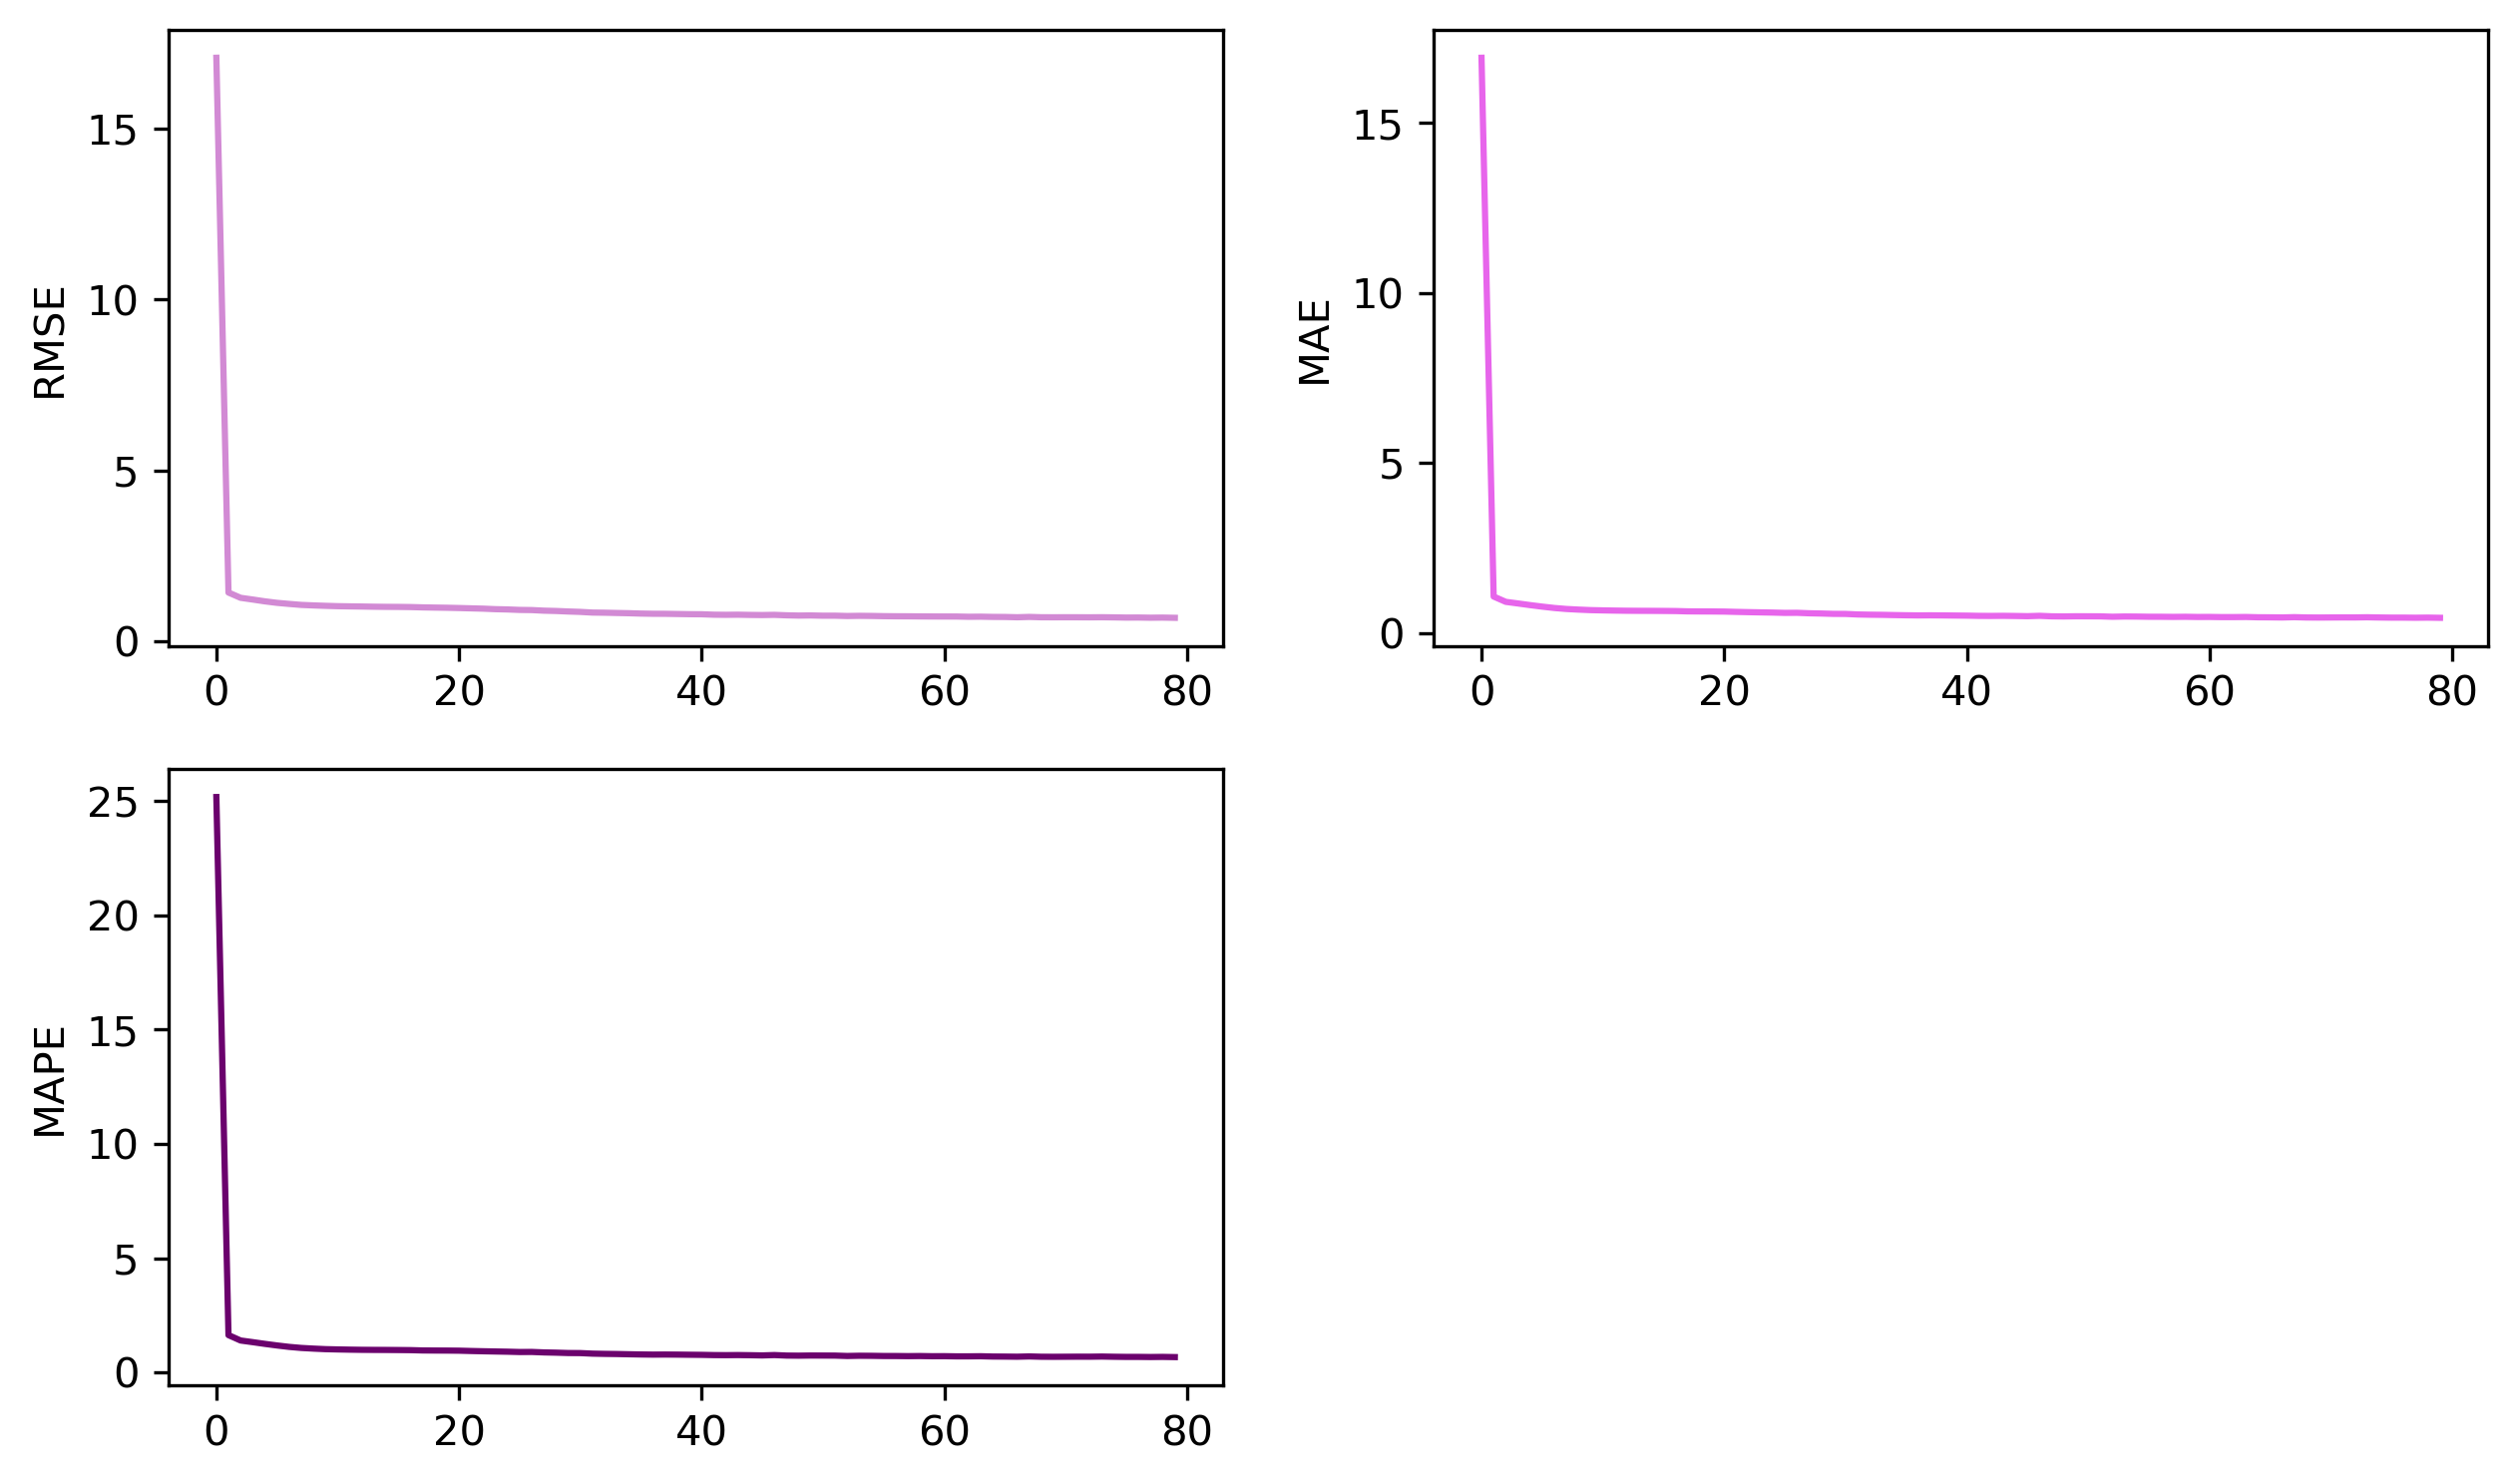

In [21]:
# 调用实现LSTM

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst,     train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)


visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)




*** epoch1, train loss 0.3174, train rmse 13.0622, val loss 0.0306, val rmse 4.249986, time use 0.454s
*** epoch2, train loss 0.0054, train rmse 1.6969, val loss 0.0042, val rmse 1.543354, time use 0.483s
*** epoch3, train loss 0.0038, train rmse 1.4838, val loss 0.0039, val rmse 1.500335, time use 0.512s
*** epoch4, train loss 0.0035, train rmse 1.4268, val loss 0.0036, val rmse 1.427259, time use 0.449s
*** epoch5, train loss 0.0032, train rmse 1.3573, val loss 0.0033, val rmse 1.366182, time use 0.454s
*** epoch6, train loss 0.0029, train rmse 1.2812, val loss 0.0029, val rmse 1.274008, time use 0.425s
*** epoch7, train loss 0.0025, train rmse 1.1999, val loss 0.0026, val rmse 1.207816, time use 0.437s
*** epoch8, train loss 0.0022, train rmse 1.1188, val loss 0.0023, val rmse 1.133215, time use 0.425s
*** epoch9, train loss 0.0019, train rmse 1.0514, val loss 0.0021, val rmse 1.088711, time use 0.427s
*** epoch10, train loss 0.0018, train rmse 1.0008, val loss 0.0019, val rmse 1.04

*** epoch79, train loss 0.0008, train rmse 0.6500, val loss 0.0011, val rmse 0.730752, time use 0.399s
*** epoch80, train loss 0.0008, train rmse 0.6533, val loss 0.0010, val rmse 0.706461, time use 0.494s

****************************************
Final result:
Get best validation rmse 0.7065 at epoch 79
Total time 34.15s

Test result:
Test RMSE: 0.5116981601504041    Test MAE: 0.31484431570226495    Test MAPE: 0.4852288364517418


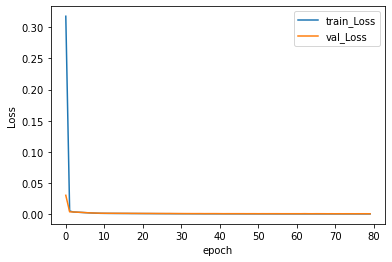

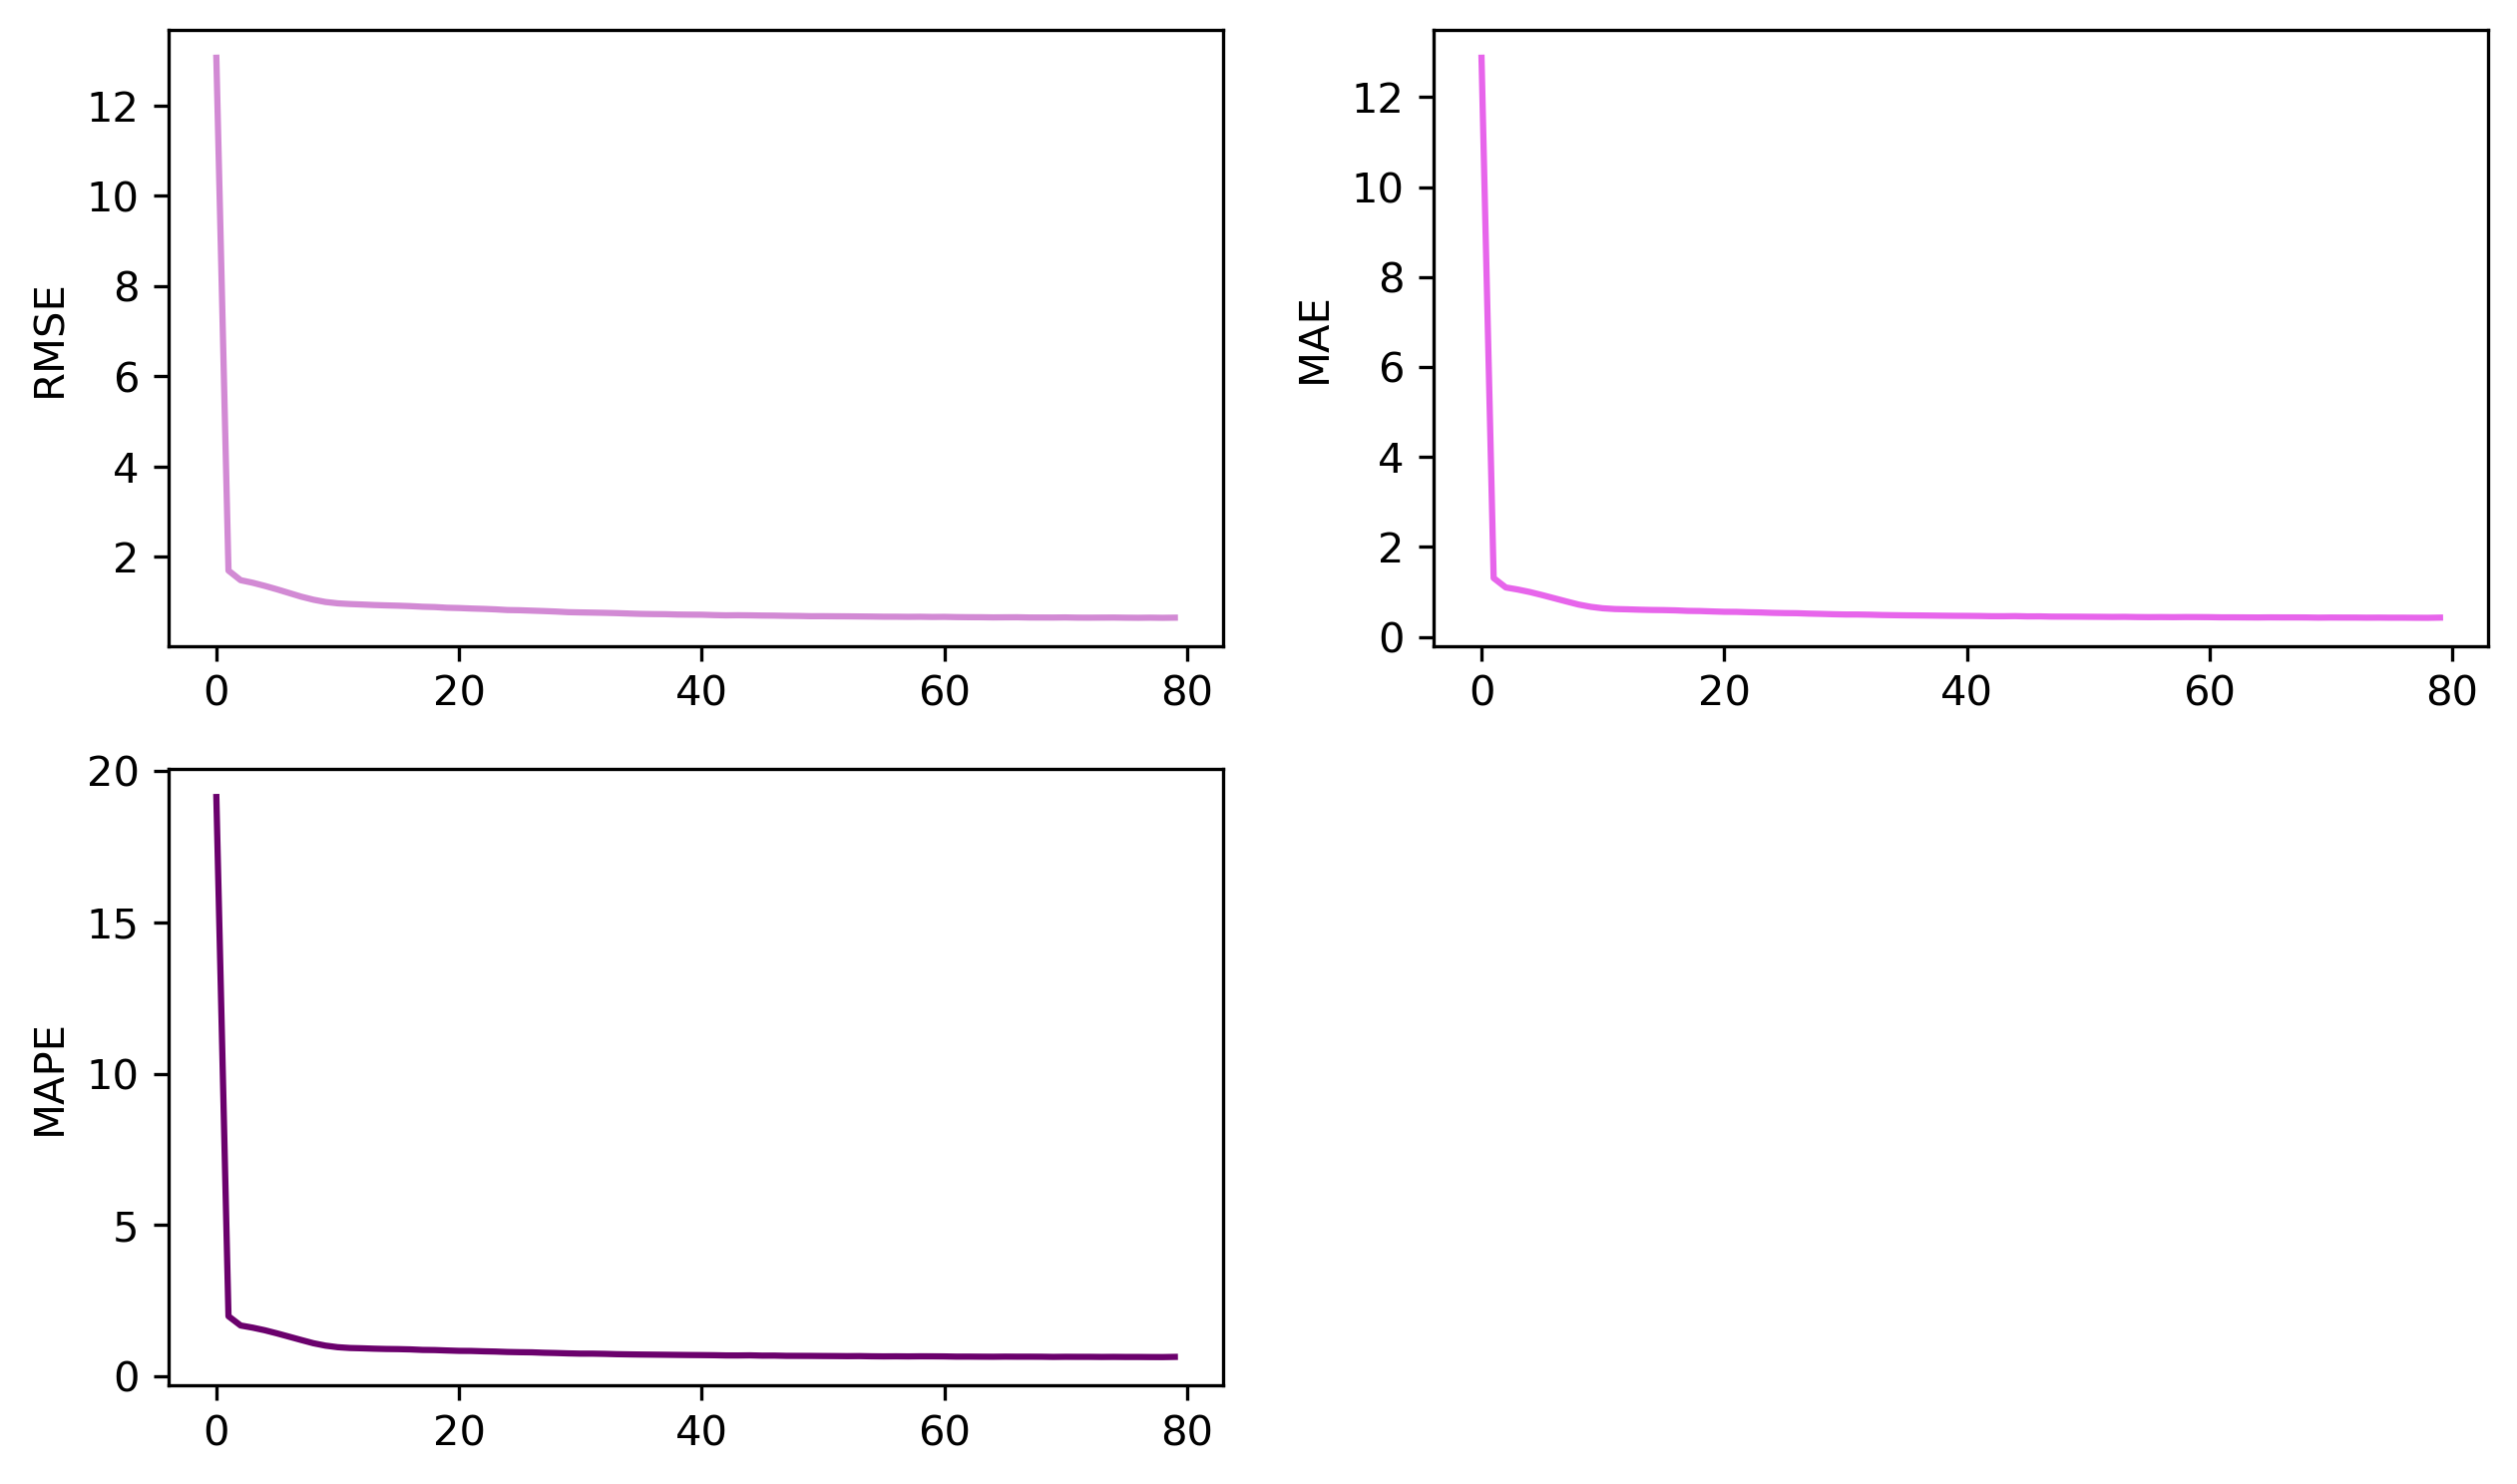

In [23]:
# 调用实现GRU

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 

nn_rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst,     train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)


visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)


## 3.3 实验结果分析
单从训练函数和预测函数的损失来看，RNN的效果略好于GRU，GRU的效果略好于LSTM，是由于RNN采用了循环网络机制，提高计算效率，LSTM从原理的角度上优化性能略差于LSTM。GRU在79轮次数达到最佳训练效果，RNN在51轮次数达到最佳训练效果，LSTM在78轮达到了最佳训练效果；从训练时间入手，RNN的时间大于GRU和LSTM的时间，从三个封装测试函数入手而言，似乎RNN的效果和GRU的效果类似，由此在本次训练中，RNN在模型优化的效果方面略好于其他模型。

# 四、超参数对比

## 4.1 任务内容

1. 任务具体要求
    1. 不同超参数的对比分析（包括hidden_size、batch_size、lr等）选其中至少1-2个进行分析
2. 任务目的
    1. 分析超参数不同对循环神经网络算法的影响
3. 任务所用数据集
    1. 高速公路车流量数据

## 4.2 任务思路及代码

1. 导入数据（训练集和测试集）
2. 建立对应神经网络（修改对应超参数）
3. 将数据放入求解器进行训练
4. 分析结果

*** epoch1, train loss 0.2904, train rmse 12.4842, val loss 0.0084, val rmse 2.207624, time use 0.547s
*** epoch2, train loss 0.0071, train rmse 2.0182, val loss 0.0067, val rmse 1.965723, time use 0.467s
*** epoch3, train loss 0.0062, train rmse 1.8894, val loss 0.0060, val rmse 1.847072, time use 0.424s
*** epoch4, train loss 0.0053, train rmse 1.7538, val loss 0.0049, val rmse 1.673055, time use 0.426s
*** epoch5, train loss 0.0044, train rmse 1.5934, val loss 0.0043, val rmse 1.559856, time use 0.431s
*** epoch6, train loss 0.0035, train rmse 1.4227, val loss 0.0033, val rmse 1.365787, time use 0.457s
*** epoch7, train loss 0.0028, train rmse 1.2683, val loss 0.0028, val rmse 1.256292, time use 0.520s
*** epoch8, train loss 0.0024, train rmse 1.1781, val loss 0.0026, val rmse 1.199530, time use 0.449s
*** epoch9, train loss 0.0023, train rmse 1.1476, val loss 0.0026, val rmse 1.198952, time use 0.425s
*** epoch10, train loss 0.0023, train rmse 1.1305, val loss 0.0025, val rmse 1.18

*** epoch79, train loss 0.0009, train rmse 0.6985, val loss 0.0012, val rmse 0.793196, time use 0.444s
*** epoch80, train loss 0.0009, train rmse 0.6919, val loss 0.0012, val rmse 0.795613, time use 0.434s

****************************************
Final result:
Get best validation rmse 0.7715 at epoch 76
Total time 35.83s

Test result:
Test RMSE: 0.6032592709046517    Test MAE: 0.4074227896603671    Test MAPE: 0.6290439558638767


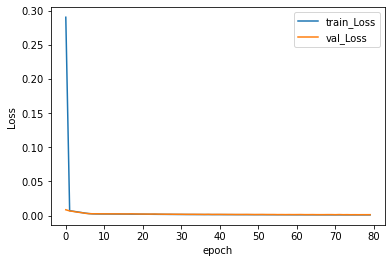

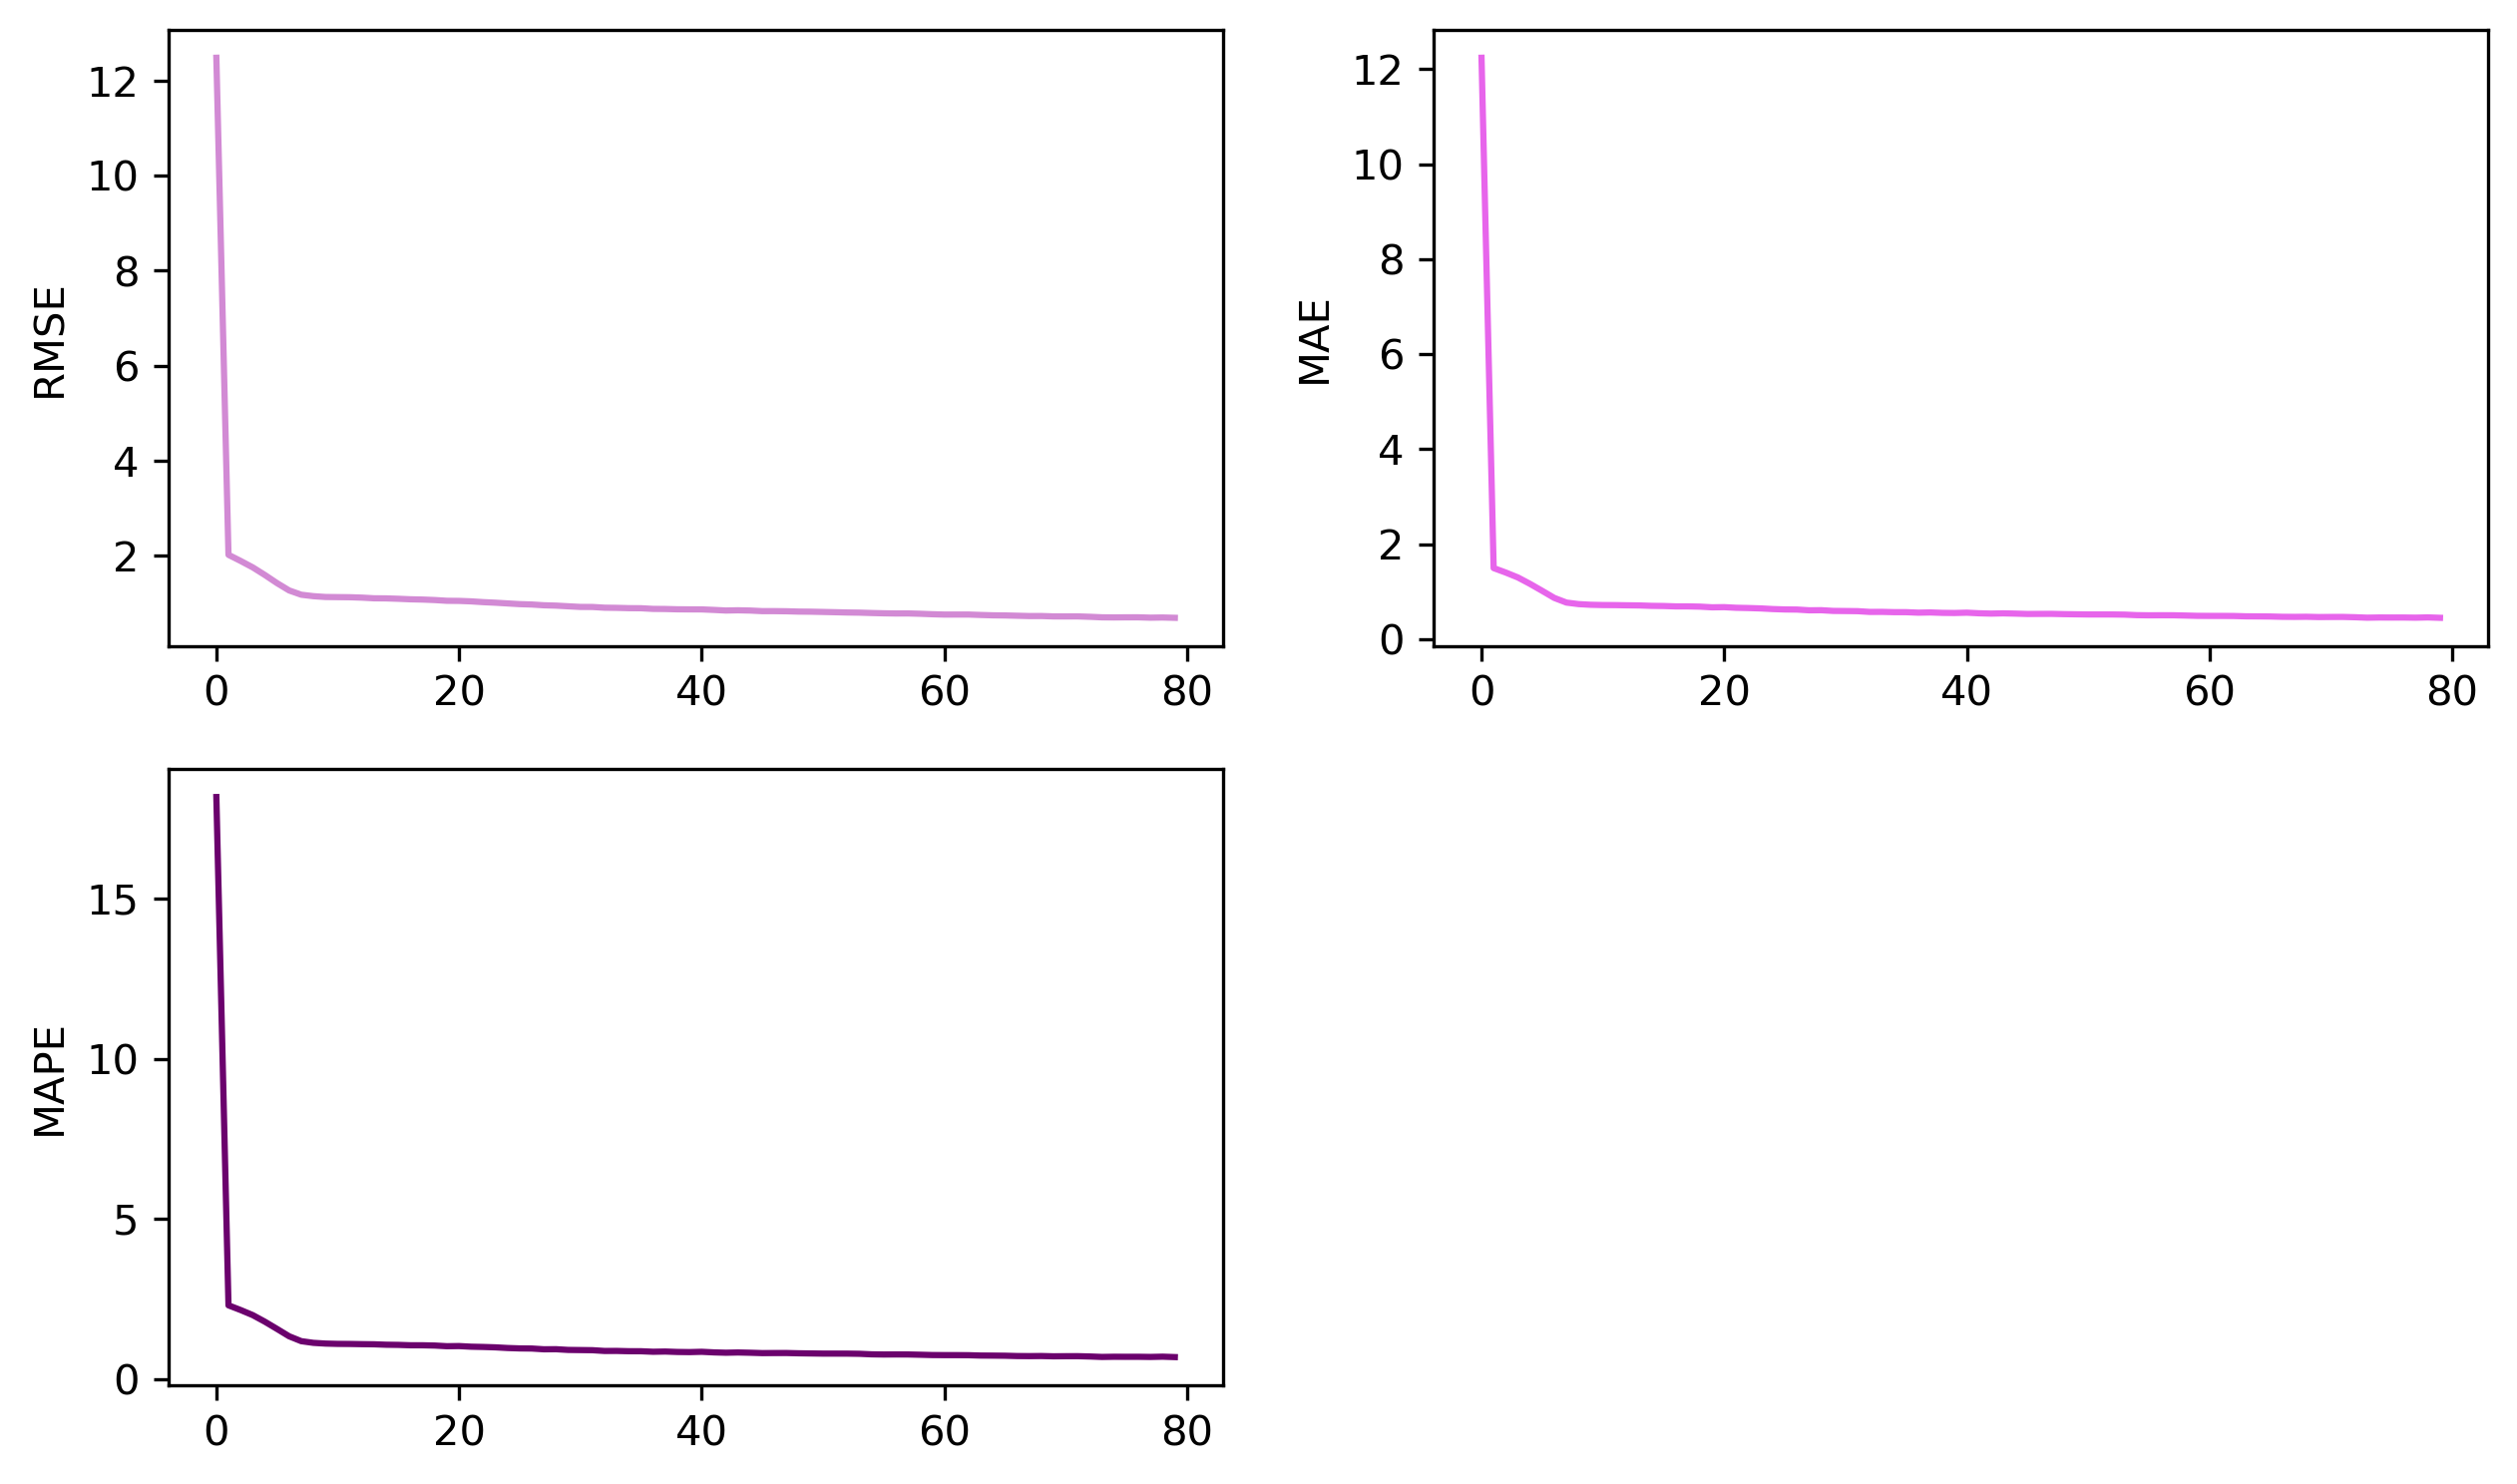

In [30]:
# 原始代码

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)


visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)


*** epoch1, train loss 0.0413, train rmse 3.3740, val loss 0.0055, val rmse 1.765598, time use 0.542s
*** epoch2, train loss 0.0030, train rmse 1.2798, val loss 0.0023, val rmse 1.131561, time use 0.423s
*** epoch3, train loss 0.0019, train rmse 1.0508, val loss 0.0020, val rmse 1.058581, time use 0.438s
*** epoch4, train loss 0.0018, train rmse 0.9988, val loss 0.0021, val rmse 1.077680, time use 0.509s
*** epoch5, train loss 0.0016, train rmse 0.9515, val loss 0.0018, val rmse 0.993598, time use 0.454s
*** epoch6, train loss 0.0015, train rmse 0.9164, val loss 0.0017, val rmse 0.964291, time use 0.430s
*** epoch7, train loss 0.0014, train rmse 0.8760, val loss 0.0016, val rmse 0.915375, time use 0.411s
*** epoch8, train loss 0.0013, train rmse 0.8538, val loss 0.0021, val rmse 1.082388, time use 0.409s
*** epoch9, train loss 0.0013, train rmse 0.8443, val loss 0.0015, val rmse 0.913158, time use 0.408s
*** epoch10, train loss 0.0012, train rmse 0.8002, val loss 0.0014, val rmse 0.876

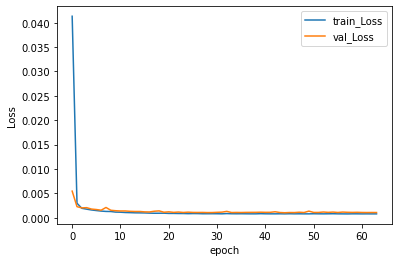

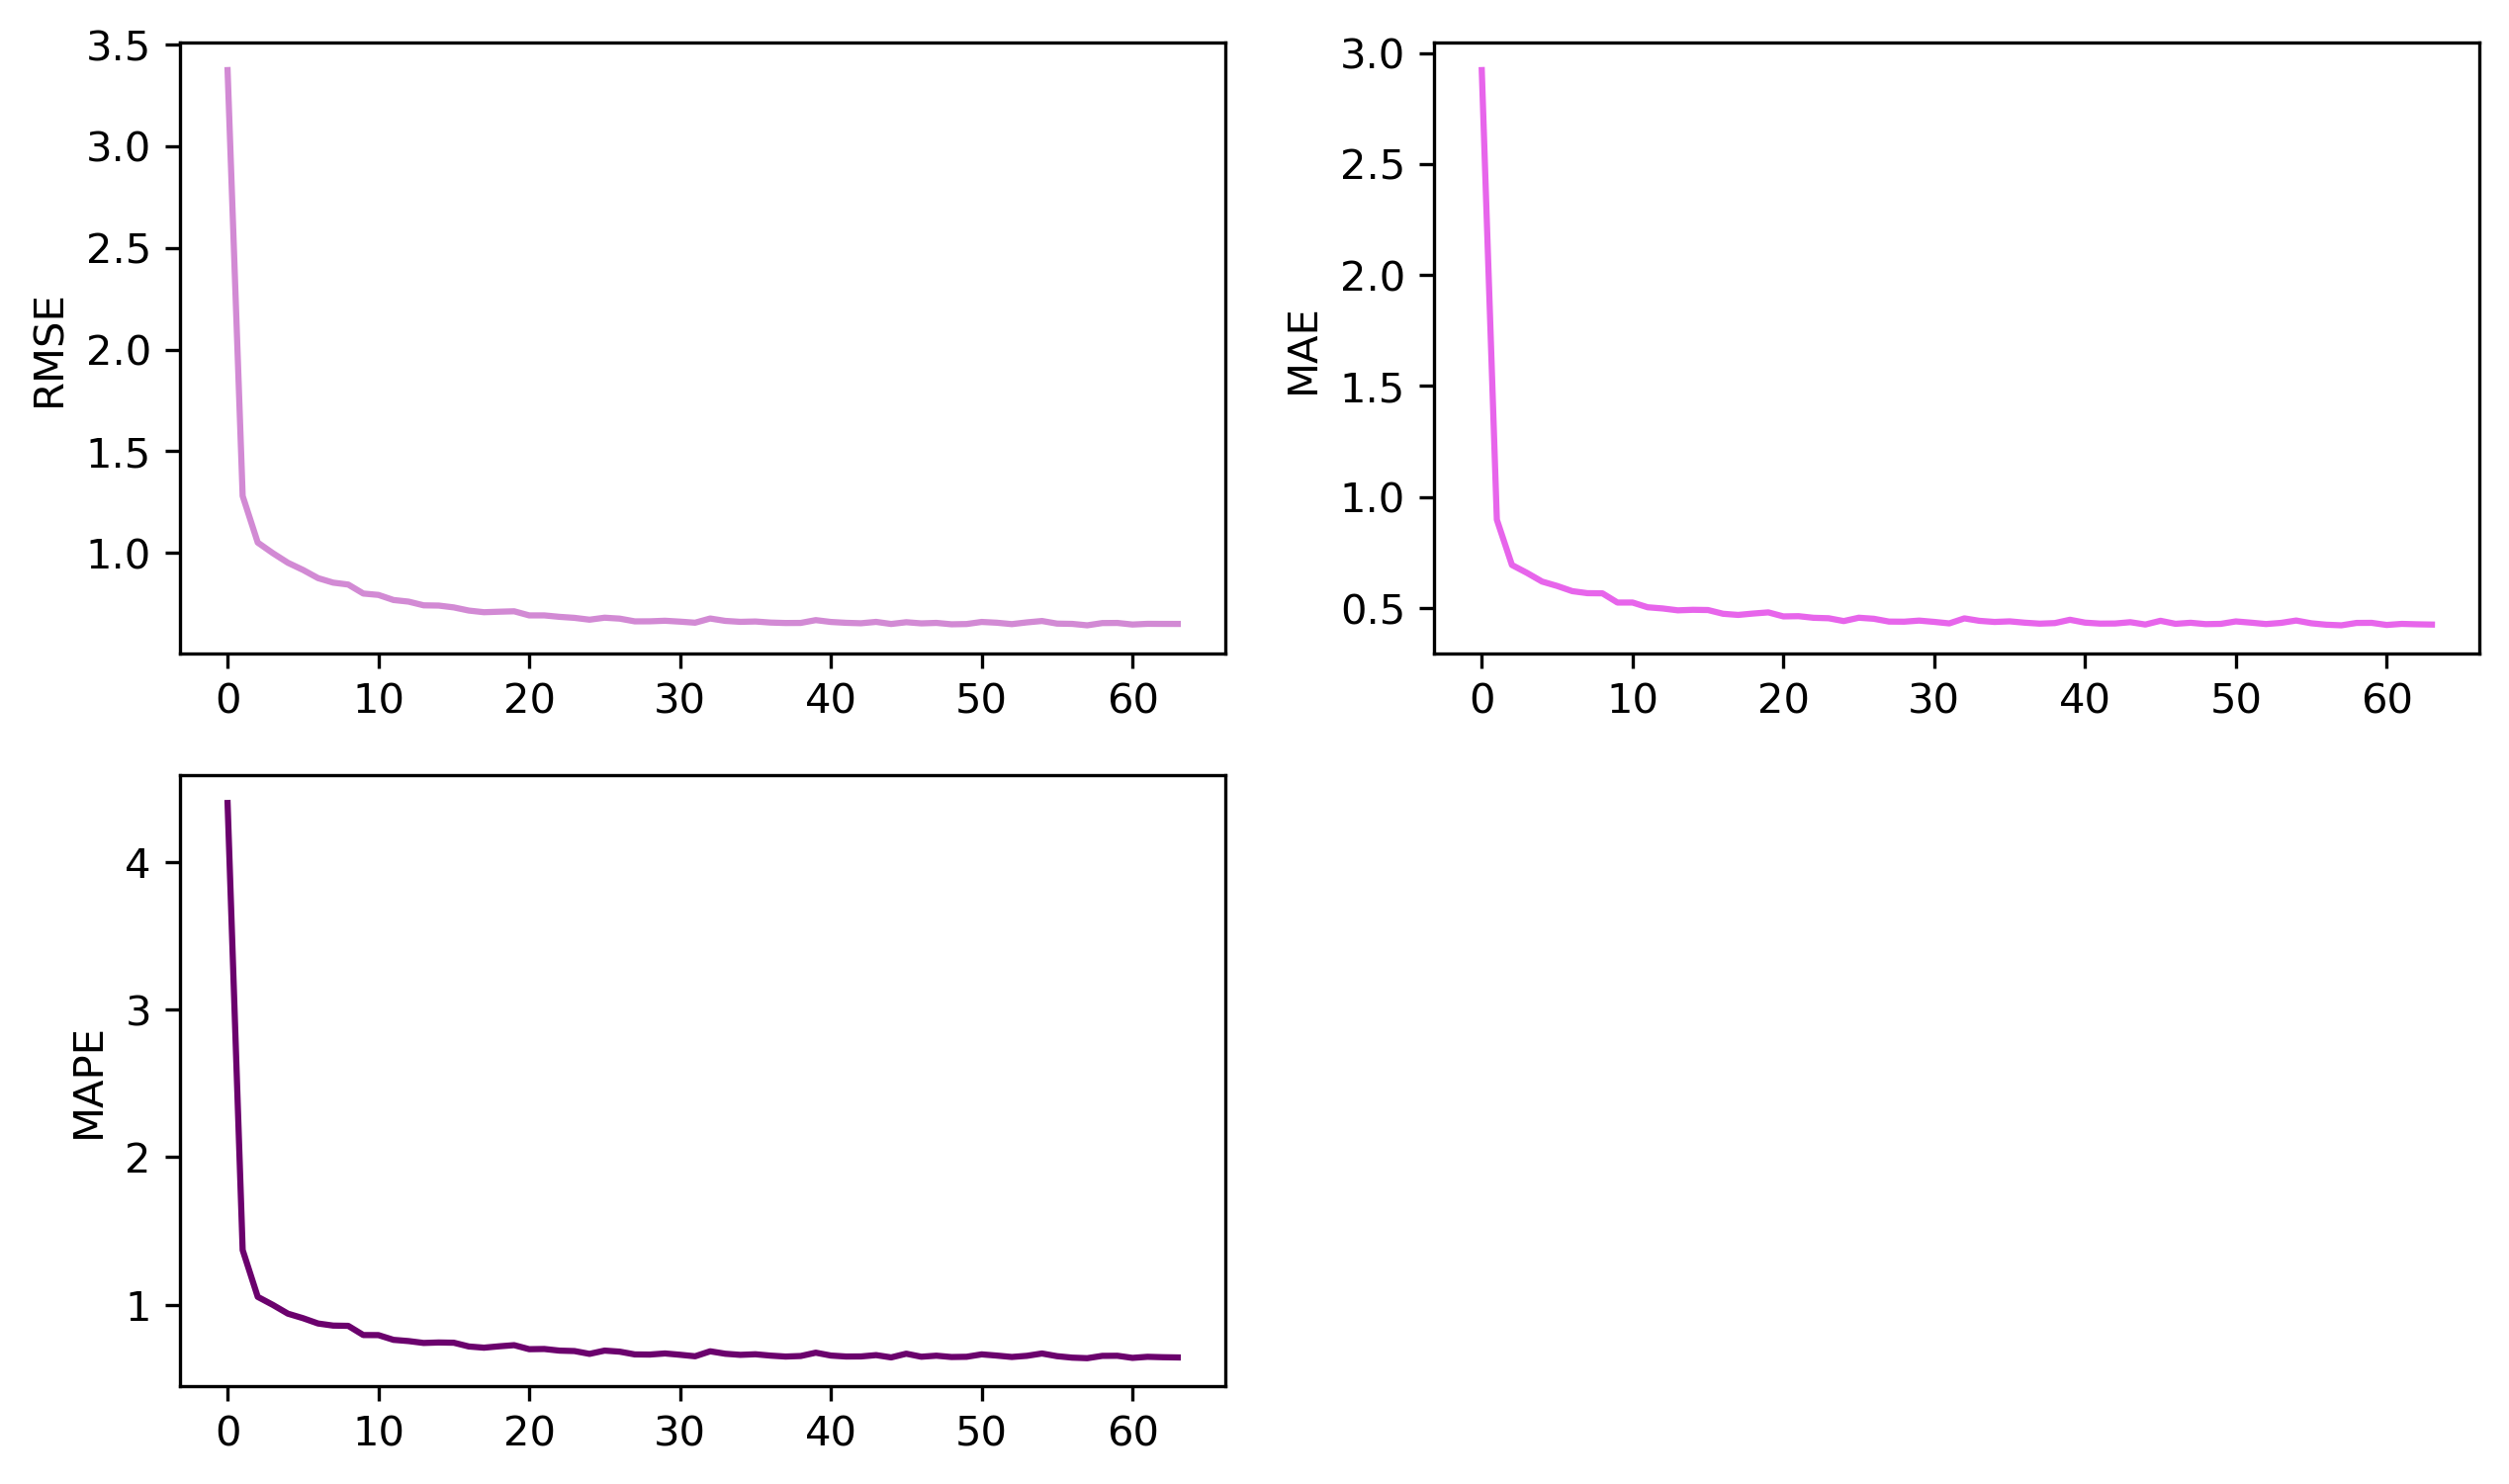

In [31]:
# 改变学习率从0.0001到0.001

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.001
epochs = 80
loss_func = nn.MSELoss() 

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)


visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)


## 4.3.1 实验结果分析
如图是选用不同的学习率（lr=0.0001/0.001）的情况下两个不同训练函数的模型，其中当学习率较大时，预测的损失并没有学习率较小时平滑，在三个评估函数中，较大的学习率在评估函数上也存在一定的抖动现象，这主要原因是采用的学习率较大，导致对模型的评估不准确，从而使测试结果处于一个不断波动的情况，尽管如此，由于学习率还是相对较小的，因此总体而言差异不大。

*** epoch1, train loss 0.5162, train rmse 17.3701, val loss 0.3243, val rmse 13.837114, time use 0.485s
*** epoch2, train loss 0.0862, train rmse 5.7082, val loss 0.0058, val rmse 1.824466, time use 0.509s
*** epoch3, train loss 0.0055, train rmse 1.7807, val loss 0.0055, val rmse 1.771499, time use 0.483s
*** epoch4, train loss 0.0052, train rmse 1.7315, val loss 0.0052, val rmse 1.716584, time use 0.550s
*** epoch5, train loss 0.0048, train rmse 1.6644, val loss 0.0048, val rmse 1.645398, time use 0.473s
*** epoch6, train loss 0.0044, train rmse 1.5796, val loss 0.0043, val rmse 1.557302, time use 0.417s
*** epoch7, train loss 0.0038, train rmse 1.4827, val loss 0.0037, val rmse 1.460220, time use 0.505s
*** epoch8, train loss 0.0032, train rmse 1.3640, val loss 0.0032, val rmse 1.339623, time use 0.456s
*** epoch9, train loss 0.0027, train rmse 1.2408, val loss 0.0027, val rmse 1.234635, time use 0.435s
*** epoch10, train loss 0.0023, train rmse 1.1486, val loss 0.0025, val rmse 1.1

*** epoch79, train loss 0.0010, train rmse 0.7335, val loss 0.0013, val rmse 0.795280, time use 0.404s
*** epoch80, train loss 0.0009, train rmse 0.7186, val loss 0.0013, val rmse 0.798760, time use 0.415s

****************************************
Final result:
Get best validation rmse 0.7953 at epoch 78
Total time 36.39s

Test result:
Test RMSE: 0.5946265761590495    Test MAE: 0.37311488823457195    Test MAPE: 0.5774287083609537


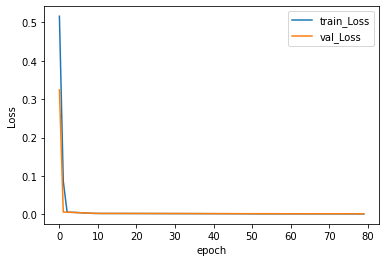

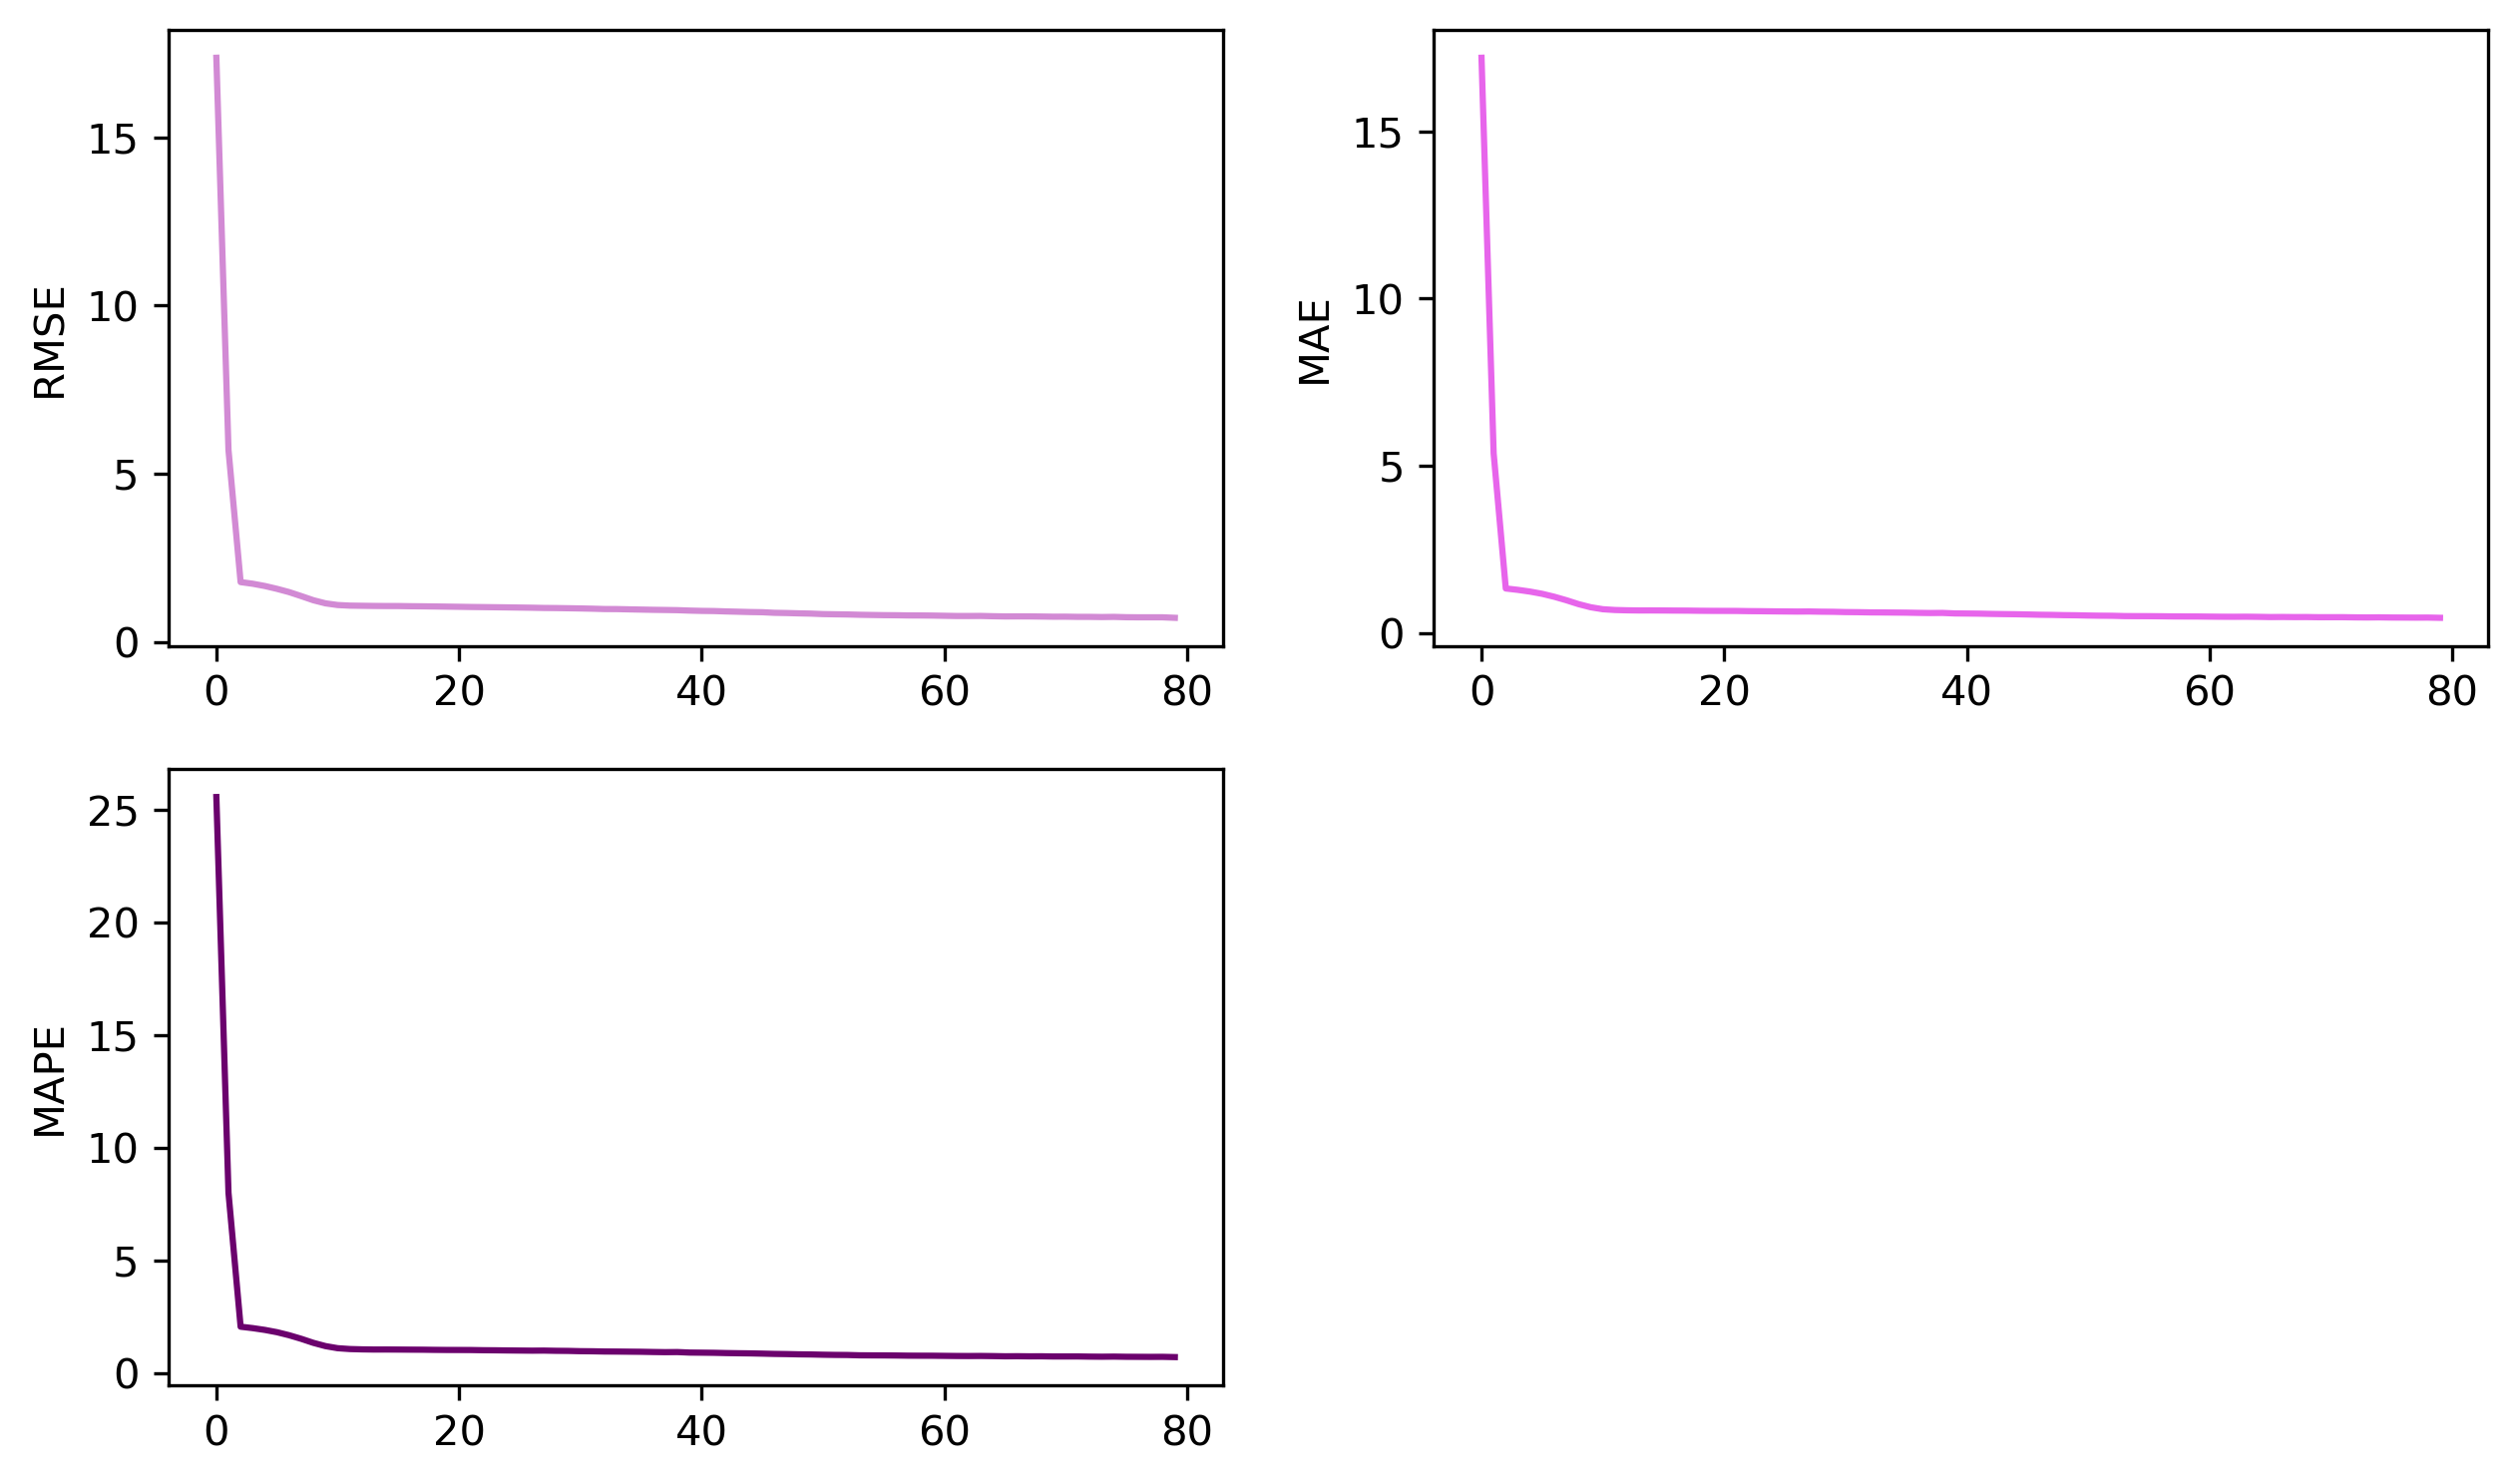

In [32]:
# 改变隐藏层从64到32
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 32
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)


visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)


## 4.3.2 实验结果分析
如图是选用不同的隐藏层（hidden_size=64/32）的情况下两个不同训练函数的模型，其中当隐藏较小时，训练的精度相对较低，对应的三个评价函数的下降速度也是相对较慢的，在对最终数据影响不大的情况下还是有一定的参考价值。

*** epoch1, train loss 0.4528, train rmse 16.3111, val loss 0.3439, val rmse 14.249231, time use 0.359s
*** epoch2, train loss 0.1617, train rmse 8.9034, val loss 0.0053, val rmse 1.760436, time use 0.264s
*** epoch3, train loss 0.0047, train rmse 1.6552, val loss 0.0046, val rmse 1.632680, time use 0.250s
*** epoch4, train loss 0.0043, train rmse 1.5747, val loss 0.0044, val rmse 1.603752, time use 0.229s
*** epoch5, train loss 0.0041, train rmse 1.5460, val loss 0.0042, val rmse 1.564072, time use 0.277s
*** epoch6, train loss 0.0039, train rmse 1.5105, val loss 0.0041, val rmse 1.537871, time use 0.207s
*** epoch7, train loss 0.0037, train rmse 1.4743, val loss 0.0038, val rmse 1.492654, time use 0.197s
*** epoch8, train loss 0.0036, train rmse 1.4395, val loss 0.0037, val rmse 1.468333, time use 0.229s
*** epoch9, train loss 0.0034, train rmse 1.3996, val loss 0.0035, val rmse 1.414321, time use 0.202s
*** epoch10, train loss 0.0032, train rmse 1.3566, val loss 0.0033, val rmse 1.3

*** epoch79, train loss 0.0012, train rmse 0.8340, val loss 0.0016, val rmse 0.932447, time use 0.219s
*** epoch80, train loss 0.0012, train rmse 0.8400, val loss 0.0015, val rmse 0.912976, time use 0.223s

****************************************
Final result:
Get best validation rmse 0.9130 at epoch 79
Total time 17.73s

Test result:
Test RMSE: 0.7029347513535001    Test MAE: 0.43262503102973654    Test MAPE: 0.6706565118360298


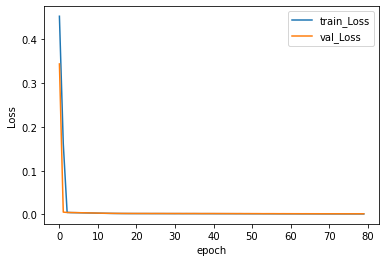

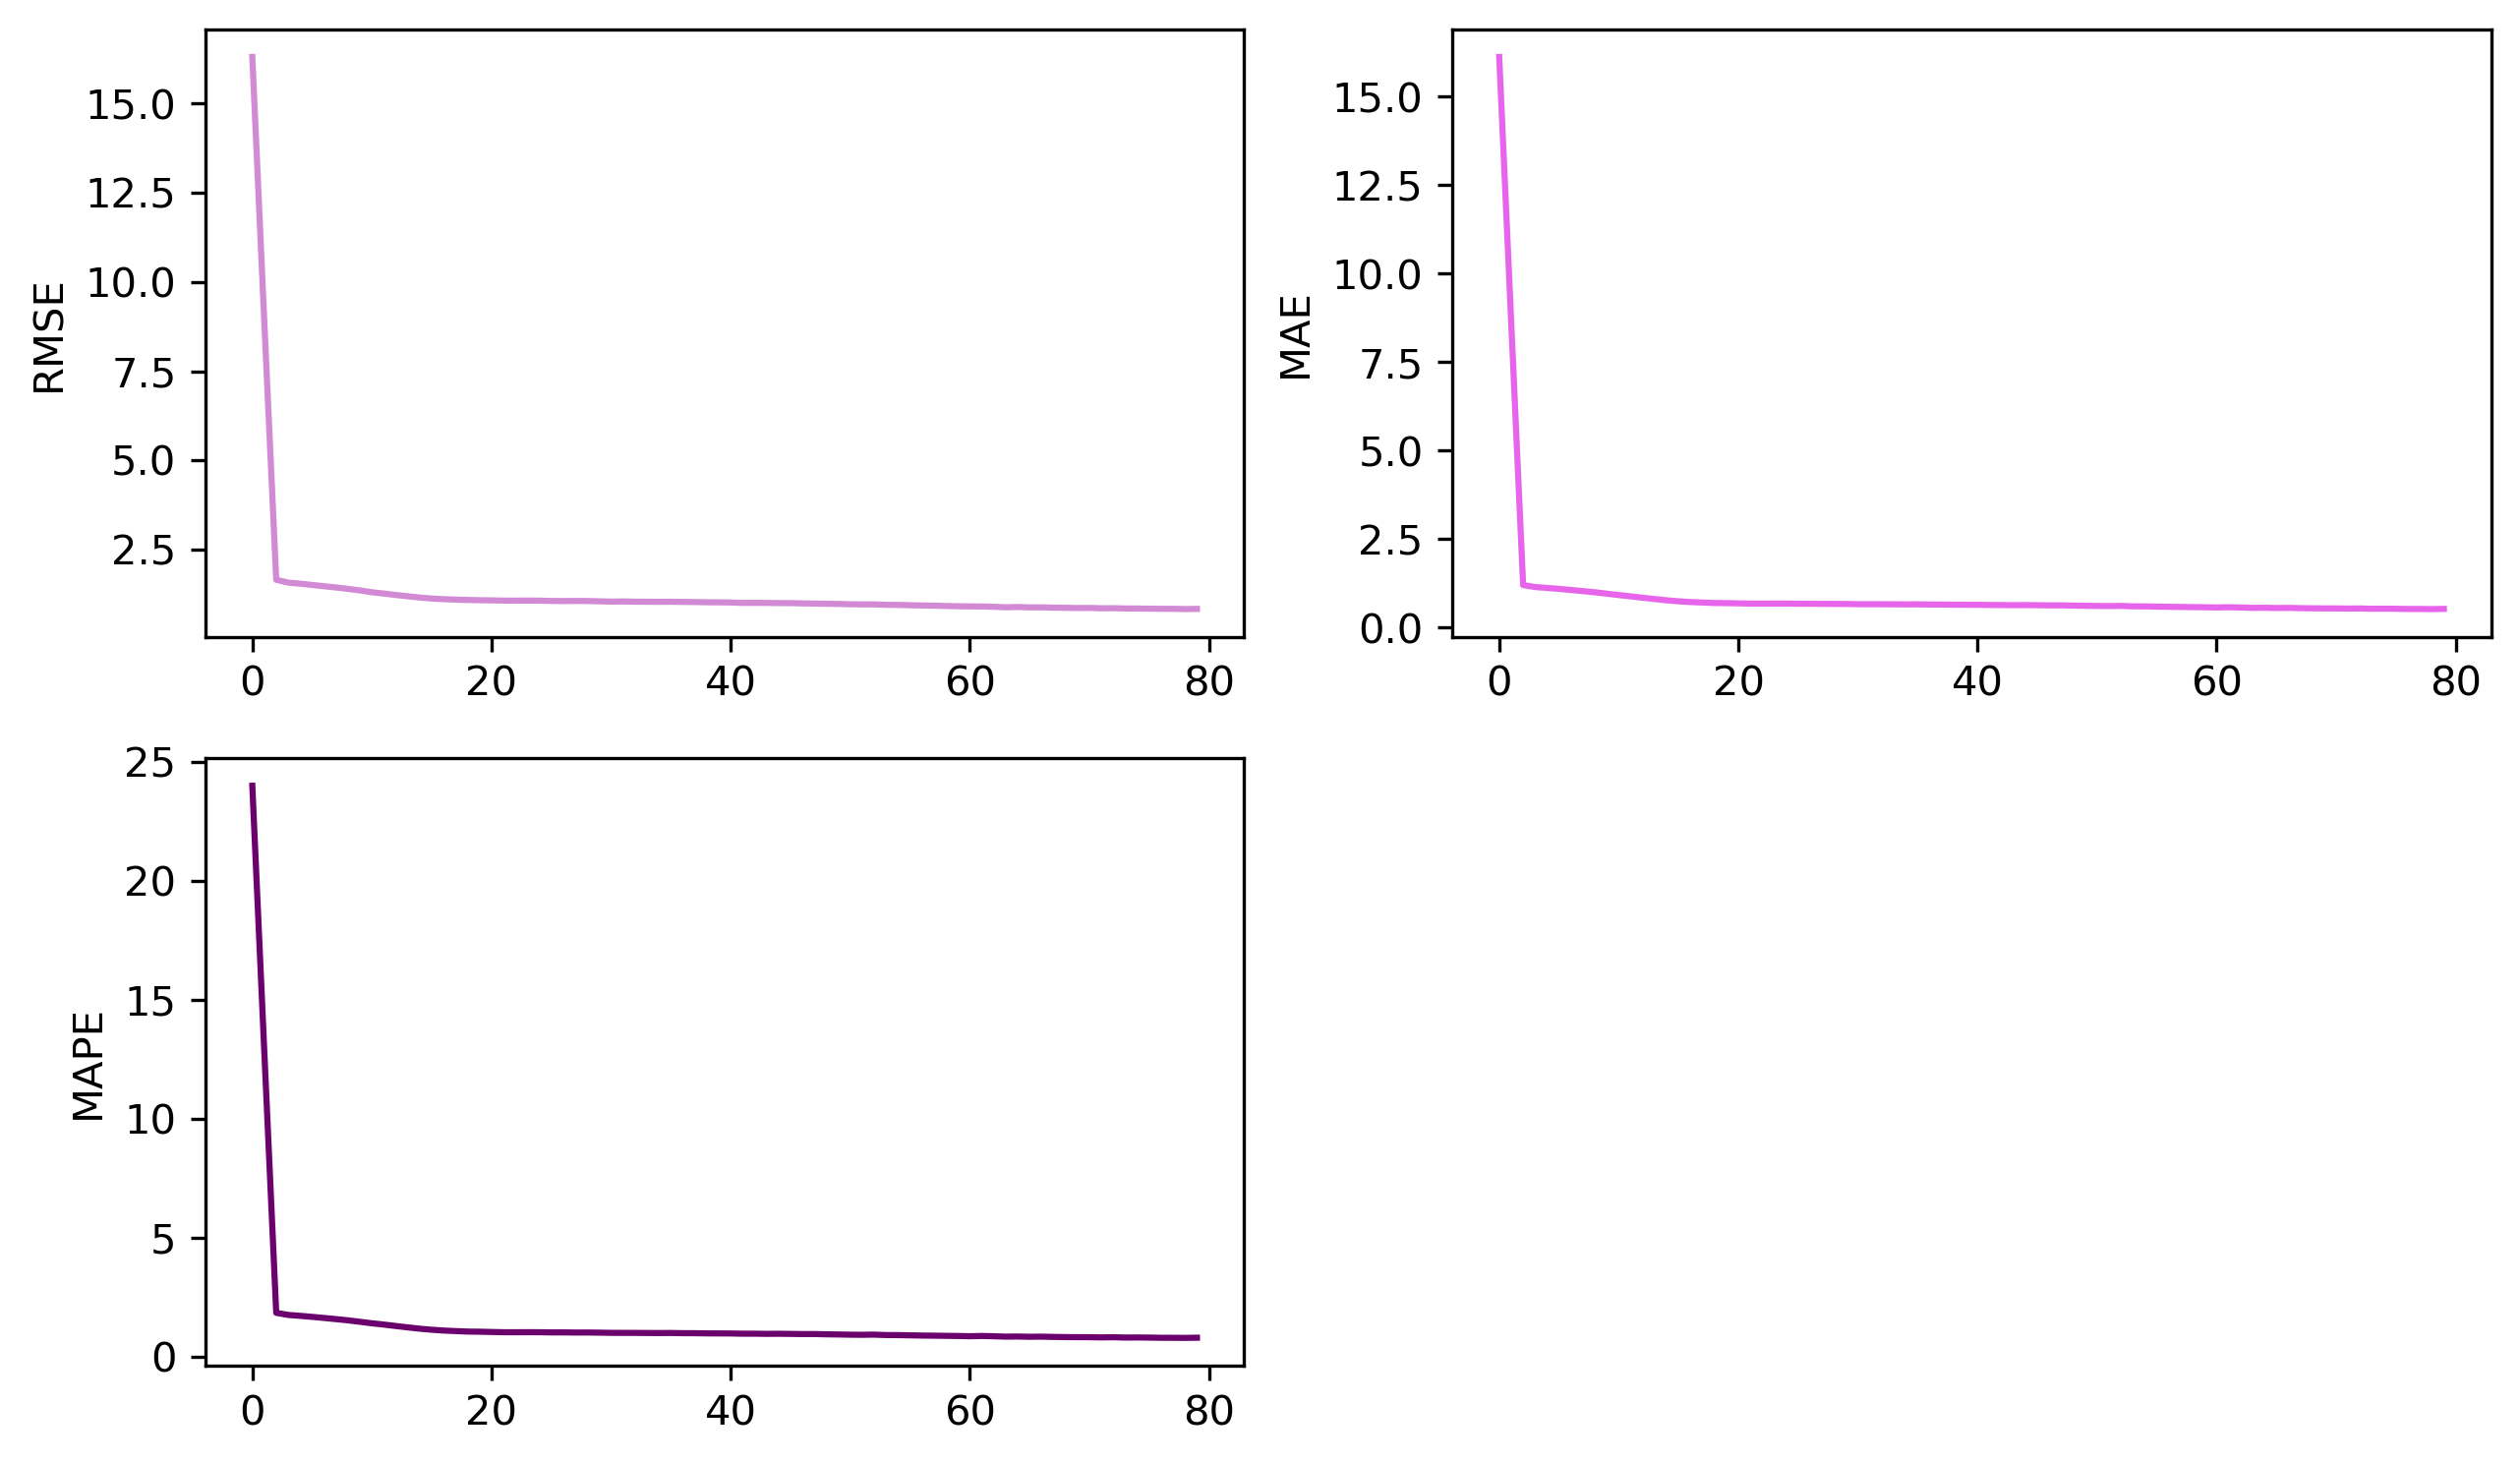

In [34]:
# 改变batch_size从64到128

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'D:\hard\deeplearning_jupyter\深度学习实验4\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 128    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)


visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)


## 4.3.3 实验结果分析
如图是选用不同的读取速度（batch_size=64/128）的情况下两个不同训练函数的模型，虽然读取的速度快可以将采样时间减少一半的时间，但是其最大的缺点在训练精度上的不足，其他参数下的训练损失多在0.001左右，而较大读取速度下的训练损失达到了0.0015左右，当应用到其他复杂情况时还是有所不足的。该训练模型同样在训练评价函数较大，下降速率慢，因此在条件允许的情况下，需要进一步减少读取样本的数量。

# A1 实验心得

1. 心得：
    1. 这次实验是卷积神经网络实验，我们需要使用卷积神经网络，长短期记忆神经网络和门循环神经网络完成对数据的预测。相比于之前的其他实验，这次验考验的是对神经网络知识的综合应用，既包含了神经网络的定义，也需要掌握一定的面向对象编程语言的知识去解决实际问题。相对而言，这次的实验比之前的实验更有难度，相对参考的代码也并不是很多。
    2. 而我这次实验也完全参考了PPT，摆脱了对CSDN的依赖， 真正利用所学的知识去解决实际问题。当然在这个过程中也是遇到了很多问题，最开始碰到的问题就数组越界的问题，产生这部分问题的主要原因就是在模型定义的时候没有数据的返回类型与数据维度的问题，从而产生了数据的不匹配。当然我参考了相关内容也知道了，最大的问题就是出现在了我返回的时候。返回数组顺序颠倒，我修改了相关的代码，成功的解决了相关问题。第二个问题就是在模型预测方面，模型的预测输出数据量不匹配的问题。出现这个问题的原因并不是因为代码报错，而是因为在模型定义的时候，格式的对齐问题由于格式的不对，其从而导致了数据的赋值出现了错误，这就导致了输出的不匹配。后来我仔细检查了代码，重新一行一行的验证，逐行输出，从而找到了问题的所在。
    3. 最后就是采取调用接口实现相关功能的时候，由于我在数据定义的时候没有按照相关的格式进行输入，从而导致了有些地方出现了相关数据没有定义的报错。这也是Python语言最大的特点之一，这就是对语言的要求较高，只有认真细致才能慢工出细活。这次实验我真正是依靠自己完成的，并没有参考过多的CSDN代码，这是我能力提升的一个过程，当然在这个过程中我也发现了自己的不足之处，就是不够细致。在以后的学习，工作和生活中，我会更加谨慎细致，认真处理好每一个细节问题。

# A2 参考文献

1. [PyTorch官方文档](https://pytorch.org/docs/stable/index.html)
2. 邱锡鹏.神经网络与深度学习[M].北京：机械工业出版社，2020.